# Proyecto de procesamiento de documentos para mejorar OCR

OCR (Optical Character Recognition) consiste en automatizar la tabulación de documentos, y pasar de un documento en fomato imagen (.pdf o .png) a un formato de texto. En este proyecto utilizamos la API Google Vision:

https://cloud.google.com/vision/docs/quickstart

El objetivo es tratar de mejorar la calidad del resultado via un procesamiento de las imagenes antes de pasarlas a la API de Google. Nuestra variable de mérito es entonces la calidad del output de la API de Google.

Este proyecto está estructurado en varias partes:

   - DocumentPreprocessing: el notebook actual, en el que exploramos algunas herramientas de procesamiento de imagenes que contienen texto: substracción del ruido medio, thresholding..
   - DenoisingAutoencoder: en este notebook desarrollamos un modelo de Machine Learning llamado AutoEncoder (autocodificador), que consiste en una red neuronal que tiene como objetivo limpiar las imagenes de entrada.
   - BMVCblurRemoval: en esta parte utilizamos un modelo pre-entrenado que reduce el ruido por desfocalización, imagenes borrosas tomadas con la camara des movil por ejemplo pueden ser recuperadas eficazmente.


# 1. Sustracción de ruido

El primer metodo que exploramos es la substracción de ruido de los documentos. Este consiste a utilizar una ventana deslizante que calcula el valor medio de la intensidad de los pixeles y sustraerlo para cada pixel de la imagen. Este método tiene 2 hperparámetros: el tamaño de la ventana (kernel o filtro), y el threshold de la intensidad de los pixeles q los aue hay que sustraer el ruido

Tomamos el ejemplo de Kaggle:

https://www.kaggle.com/rdokov/background-removal/code

## 1.1 Importación de librerías y ejemplo de Kaggle

Uno de las competencias de Kaggle consistía en limpiar utilizando modelos de Machine Learning documentos escaneados que contienen ruido y que son poco legibles. Es un buen ejemplo para comenzar, asi que descargamos los datos en 
    ./data/KaggleDenoising
    
Importamos la librerías correspondientes y cargamos tres funciones: load_image(), save() y denoise_image()

In [3]:
import numpy as np
from scipy import signal
from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave

def load_image(path):
    return np.asarray(Image.open(path))/255.0

def save(path, img):
    tmp = np.asarray(img*255.0, dtype=np.uint8)
    Image.fromarray(tmp).save(path)

def denoise_image(inp,thresh = 0.1, kernel = 11, name = "test"):
    # estimate 'background' color by a median filter
    bg = signal.medfilt2d(inp, kernel)
    #save(name+'background.png', bg)

    # compute 'foreground' mask as anything that is significantly darker than
    # the background
    mask = inp < bg - thresh
    #save(name+'foreground_mask.png', mask)

    # return the input value for all pixels in the mask or pure white otherwise
    return np.where(mask, inp, 1.0), bg


inp_path = './data/KaggleDenoising/train/2.png'
#inp_path = './data/Ivan/test.png'
out_path = './data/KaggleDenoising/testoutput.png'

inp = load_image(inp_path)
out, bg = denoise_image(inp)

save(out_path, out)

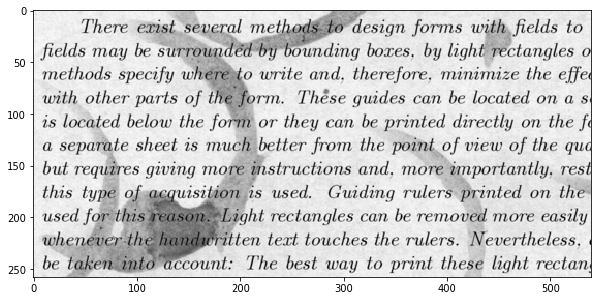

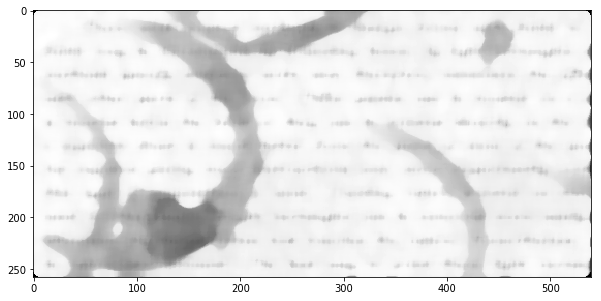

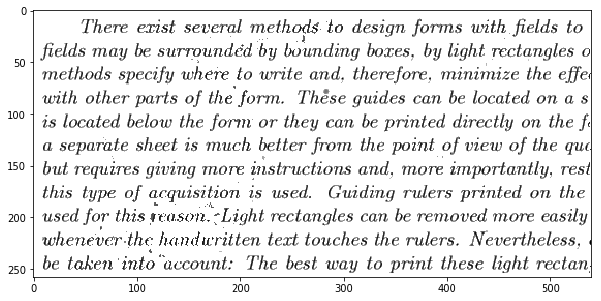

In [4]:
out = np.asarray(out*255.0, dtype=np.uint8)

plt.figure(figsize=(10,10))
plt.imshow(inp, cmap='gray');
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(bg, cmap='gray');
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(out, cmap='gray');
plt.show()



Vemos exactamente lo que buscamos: la descomposición de la imagen inicial en una máscara de ruido de fondo adicionado a la parte interesante consistente en el texto.

## 1.2 En las imágenes nuestras

Ubicamos nuestro dataset de pueba en 
   - ./data/Arte/parte1.pdf
   - ./data/Arte/parte2.pdf

Utilizamos para los differentes tests las imágenes:
   - ./data/Arte/test.png
   - ./data/Arte/test2.png
   - ./data/Arte/test_p23.png (documento escrito a mano)

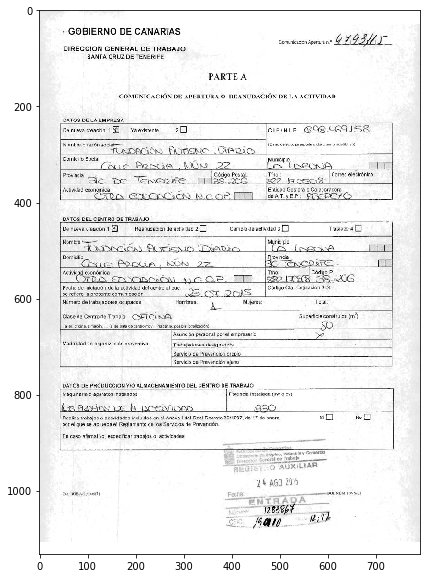

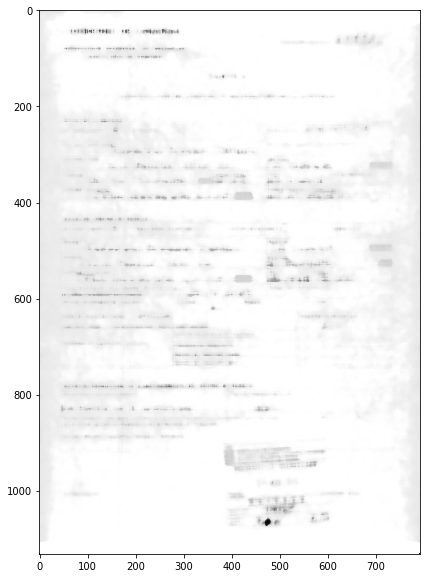

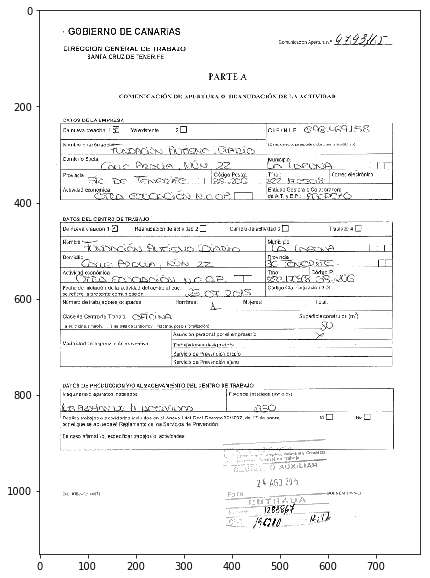

In [5]:
path = './data/Arte/test_p23.png'
input_test = load_image(path)
input_test = input_test[:, :, 0]

out_test, bg_test = denoise_image(input_test)
out_test = np.asarray(out_test*255.0, dtype=np.uint8)

plt.figure(figsize=(10,10))
plt.imshow(input_test, cmap='gray');
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(bg_test, cmap='gray');
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(out_test, cmap='gray');
plt.show()

Observamos el efecto esperado. La imagen de salida está mucho mas "limpia" y clara. Para encontrar los parámetros ideales de tamaño de filtro y threshold hacemos un Grid Search

## 1.3 Optimización de parámetros (GridSearch)

Recorremos una gran combinación de casos para los dos parámetros, y evaluamos su efecto en las imágenes que ubicamos en:
   - ./data/Arte/BackgroundRemoval/
   - ./data/Arte/BackgroundRemoval/p23/ (escritas a mano)


In [71]:
path = "./data/Arte/BackgroundRemoval/manual/"

kernels = [3, 5, 7, 9, 11, 15, 21, 25, 55, 75]
thresholds = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11]

for kernel in kernels:
    for threshold in thresholds:
        print(kernel, threshold)
        prefix = "thr_"+str(threshold)+"_ker_"+str(kernel)+"_"
        out_test, bg_test = denoise_image(input_test, threshold, kernel, path+prefix)
        out_path = path+prefix+'clean.png'
        save(out_path, out_test)

(3, 0.005)
(3, 0.01)
(3, 0.02)
(3, 0.03)
(3, 0.04)
(3, 0.05)
(3, 0.06)
(3, 0.07)
(3, 0.08)
(3, 0.09)
(3, 0.1)
(3, 0.11)
(5, 0.005)
(5, 0.01)
(5, 0.02)
(5, 0.03)
(5, 0.04)
(5, 0.05)
(5, 0.06)
(5, 0.07)
(5, 0.08)
(5, 0.09)
(5, 0.1)
(5, 0.11)
(7, 0.005)
(7, 0.01)
(7, 0.02)
(7, 0.03)
(7, 0.04)
(7, 0.05)
(7, 0.06)
(7, 0.07)
(7, 0.08)
(7, 0.09)
(7, 0.1)
(7, 0.11)
(9, 0.005)
(9, 0.01)
(9, 0.02)
(9, 0.03)
(9, 0.04)
(9, 0.05)
(9, 0.06)
(9, 0.07)
(9, 0.08)
(9, 0.09)
(9, 0.1)
(9, 0.11)
(11, 0.005)
(11, 0.01)
(11, 0.02)
(11, 0.03)
(11, 0.04)
(11, 0.05)
(11, 0.06)
(11, 0.07)
(11, 0.08)
(11, 0.09)
(11, 0.1)
(11, 0.11)
(15, 0.005)
(15, 0.01)
(15, 0.02)
(15, 0.03)
(15, 0.04)
(15, 0.05)
(15, 0.06)
(15, 0.07)
(15, 0.08)
(15, 0.09)
(15, 0.1)
(15, 0.11)
(21, 0.005)
(21, 0.01)
(21, 0.02)
(21, 0.03)
(21, 0.04)
(21, 0.05)
(21, 0.06)
(21, 0.07)
(21, 0.08)
(21, 0.09)
(21, 0.1)
(21, 0.11)
(25, 0.005)
(25, 0.01)
(25, 0.02)
(25, 0.03)
(25, 0.04)
(25, 0.05)
(25, 0.06)
(25, 0.07)
(25, 0.08)
(25, 0.09)
(25, 0.1)
(25

Ahora comparamos la salida tras aplicar la API OCR de GoogleVision sobre nuestros documentos, y la comparamos con el documento original


In [7]:
!ls ./data/Arte/GoogleVisionOutput/

manual			       thr_0.05_ker_11_clean.json
modeloA.json		       thr_0.05_ker_15_clean.json
original.json		       thr_0.05_ker_21_clean.json
outGridSearch-all	       thr_0.05_ker_25_clean.json
outGridSearch-original	       thr_0.05_ker_3_clean.json
out_test.json		       thr_0.05_ker_75_clean.json
test_img_thresh_adaptive.json  thr_0.05_ker_7_clean.json
thr_0.005_ker_15_clean.json    thr_0.05_ker_9_clean.json
thr_0.005_ker_25_clean.json    thr_0.06_ker_11_clean.json
thr_0.005_ker_3_clean.json     thr_0.06_ker_15_clean.json
thr_0.005_ker_75_clean.json    thr_0.06_ker_21_clean.json
thr_0.005_ker_7_clean.json     thr_0.06_ker_25_clean.json
thr_0.01_ker_11_clean.json     thr_0.06_ker_9_clean.json
thr_0.01_ker_15_clean.json     thr_0.07_ker_11_clean.json
thr_0.01_ker_21_clean.json     thr_0.07_ker_15_clean.json
thr_0.01_ker_25_clean.json     thr_0.07_ker_21_clean.json
thr_0.01_ker_9_clean.json      thr_0.07_ker_25_clean.json
thr_0.02_ker_11_clean.json     thr_0.07_ker_9_clean.json
thr_0.02_ke

In [10]:
import pandas as pd
data = pd.read_json("./data/Arte/GoogleVisionOutput/original.json")

In [11]:
data_2 = pd.read_json("./data/Arte/GoogleVisionOutput/manual/original.json")

print(data_2['responses'][0]['textAnnotations'][0]['description'])

• GOBIERNO DE CANARIAS
Comunicación Apertura nº
Comunicación Apertura nº 4793/JL
DIRECCION GENERAL DE TRABAJO
SANTA CRUZ DE TENERIFE
PARTE A
COMUNICACIÓN DE APERTURA O REANUDACIÓN DE LA ACTIVIDAD
DATOS DE LA EMPRESA
De nueva creación 10
Ya existente
20
CLE/NLF: 698.469358
Nombre Utazón societ
Enderedo, pasaporte o documento sustitutivo)
Domiclio Social
u Tunación Duriano Diario
Couc ARNIA NON 22
sic Taverie T3S 206
Cara que con NCOPII de AT. YEP CAO
Código Postal:
Municipio
DINGOWA
Correo electrónico
SZZ FESOS
Entidad Gestora o Colaboradora
Actividad económica
DATOS DEL CENTRO DE TRABAJO
Da nueva creacion 1 Reanudacion de actividad 2
cambio de actividad 3D
Traslaco 4
IT
Nombre
Municipio
mune tabació Actino Diadeo
com
Domicilio
Provncia
Calle Ann MN 22
STOND FC
Actividad económica
OTA ONCONCO.P.
882 175c8 38 206
Fecha de Iniciación de la actividad del centro al que a
Código Cia. Cotización S.S.
se refiere la presente comunicación
BOLOS
Número de trabajadores ocupados:
Hombres
Mujeres
To

In [12]:
data_3 = pd.read_json("./data/Arte/GoogleVisionOutput/manual/thr_0.04_ker_21_clean.json")
print(data_3['responses'][0]['textAnnotations'][0]['description'])

GOBIERNO DE CANARIAS
Comunicadon Apertura nº
DIRECCION GENERAL DE TRABAJO
SANTA CRUZ DE TENERIFE
PARTE A
A
COMUNICACIÓN DE APERTURA O REANUDACIÓN DE LA ACTIVIDAD
Enderedo, pasaporte o documento sustitutivo)
DATOS DE LA EMPRESA
De nueva creación 10 ya existente 20
CLELN.LF: 698.469158
Nombre u razón societ
TONDACIóN AUGSNO DIARIO
Domiclio Social
'caue Araca NÚM. 22 D NEQWA
Código Postal:
Correo electrónico
sic DC Tavorire 1135 206
822 76508
Actividad económica
Entidad Gestora o Colaboradora
Co mocón NCOPTI JAT. YEP, nomeno
Municipio
Tfno:
ܩܩܠ ܐܩܢܬܘܐ ܠܬܘܰܢܽܫܢ̈ܪ
DATOS DEL CENTRO DE TRABAJO
Da nueva creación 13 Reanudacion de actividad 2 cambio de actividad 3D
Traslaco 4
Nombre
Municipio
(NANA
Provincia
ĐO CÁP , XÂN 2z
SC TENERIFE
Con ucación NCOP. 1 1882 175088206
Fecha de Iniciación de la actividad del centro al que
Código Cia. Cotización S.S.
se refiere la presente comunicación
3.OLOS
Número de trabajadores ocupados:
Mujeras
Total:
Actividad eco
Superficie construida (m)
SO
Clase de Cen

In [65]:
ker = [3, 7, 15, 25, 75]
thr = [0.005, 0.05, 0.08, 0.11]

for k in ker:
    for t in thr:
        data = pd.read_json("./data/Ivan/GoogleVision/thr_{}_ker_{}_clean.json".format(t,k))
        print("===========================================")
        print(k,t)
        print(data['responses'][0]['textAnnotations'][0]['description'])

(3, 0.005)
Gobierno
de Canarias
Condicciate Eriple
statyta
PLECCO Ceneral de Trebaju
Flematización abertura
gol
COMUNICACIÓN DE APERTURA O REUNDACIÓN DE LIXTIVIDAD
DATOS DE LA EMPRESA
Daneva creaciót 10
Yaek Sun
22
CLUYLA B33520714
Nobre o fazare socal ROSE LA PALMA S.L.
paza
Bursa
Domicilio Social AVDA CARLOS FRANCISCO LORENZO NAVARRO 135
Municipio LOS LLANOS DE ARIDANE
Powiada SANTA CRUZ DE TENERIFE
Coclipo Fostat
38760
Tfno.: 922-62472 Coreece
T. 9224624
3760 Oslo
Actividad econónica COMERCIO TEXTIL
Enlirfod Gaslara Colaboradozat
AT YEPUTUA UNIVERSAL
DATOS DEL CENTRO DE TRABAJO
De nueva creación 10 Petuar
se dividad 20
Carpio ce actividad 30
Traslado 18
Nombre DO SE LA PALMA SL
S
EO LOS LLANOS DE ID2105
Domo AVDA. CARLOS FRACESCO LORENZO NAVARO NE
Providla SANTA CRUT CE TENERIFE
Adidad economica COMERCU TEXTIL
To: 422462472 Codigo P. 38769
alte
Codigo Cat Conzaciór S.S. 29104751597
Frucha deirsciació de la ficha dut
Suratare riesenis canulicado
Nun kerana adres ocupadas
Hondres: 01


(15, 0.005)
Gobierno
de Canarias
Conceria de Empleo
Industria y Comercio
Dirección General de Trabajo
Comunicacion Aserba na E790/L
COMUNICACIÓN DE APERTURA O REANUDACIÓN DE LA ACTIVIDAD
DATOS DE LA EMPRESA
De nueva creación 10
Ya existente
2
C.L.FIN.LFB38520714
Nombre o razón Social MOISE LA PALMA S.L.
En su defecto pasaporte o documentos
Domicilio Social AVOA CARLOS FRANCISCO LORENZO NAVARRO N36
Municipio LOS LLANOS DE ARIDANE
Provincia SANTA CRUZ DE TENERIFE
Código Postal
38760
Tfno. 922462472 Coreo electro
Actividad economica COMERCIO TEXTIL
Entidad Gestora o Colaboradora
de ATYEP MUTUA UNIVERSAL
DATOS DEL CENTRO DE TRABAJO
De nueva creación 10 Reanudación de actividad 2
Cambio de actividad 3
Traslado 45
Nombre MOISE LA PALMA SL
Municipio LOS LLANOS DE ARIDANE
Domicilio AVDA. CARLOS FRANCISCO LORENZO NAVARRO N°36
Provincia SANTA CRUZ DE TENERIFE
Actividad economica COMERCIO TEXTIL
Tino: 122462472 Codigo P. 38760
Codigo Cta. Cotización S.S. 38104751890
Fecha de iniciación de la acti

(25, 0.11)
Gobierno
de Canarias
Conseria de Erapeut
Industria y Comercio
Dirección General de Trabajo
Comuncación Apertura a
2 /L
COMUNICACIÓN DE APERTURA O REANUDACIÓN DE LA ACTIVIDAD
DATOS DE LA EMPRESA
De nueva creación 10
Ya existente
2
CLENLE B38520714
Nombre o razón social MOISE LA PALMA S.L.
En s
erta pesapare o dorast
Domicilio Social AVDA. CARLOS FRANCISCO LORENZO NAVARRO N36
Municipio LOS LLANOS DE ARIDANE
Provincia SANTA CRUZ DE TENERIFE
Tfno. 922462472 Core
Código Postal
38760
Actvidad economica COMERCIO TEXTIL
Entidad Gestora o Colaboradora
de AT. YEP MUTUA UNIVERSAL
DATOS DEL CENTRO DE TRABAJO
De nueva creación 10 Reanudación de actividad 20
Cambio de actividad 30
Traslado 4
Nombre TOISE LA PALMA 5L.
Municipio LOS LLANOS DE ARIDANE
Domicilio AVDA CARLOS FRANCISCO LORENZO NAVARRO N°36
Provincia SANTA CRUZ DE TENERIFE
Actividad economica COMERCIO TEXTIL
Tino: 122462472 Código P. 38760
Codigo Cta Cotización S.S. 38104751890
Fecha de iniciación de la actividad del centro al q

We make a finer grid search submitting Google vision requests for
    - Kernels : 9, 11, 15, 21, 25
    - Thresholds: 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08
Let's check the output json files and compare them with the original json response and a "truth" made by hand response

In [68]:
ker = [9, 11, 15, 21, 25]
thr = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]

for k in ker:
    for t in thr:
        data = pd.read_json("./data/Ivan/GoogleVision/thr_{}_ker_{}_clean.json".format(t,k))
        print("===========================================")
        print(k,t)
        print(data['responses'][0]['textAnnotations'][0]['description'])

(9, 0.01)
w
Gobierno
de Canarias
Conceria de Empleo
Industria y Comercio
Dirección General de Trabajo
comunicacion Aserba na E790/L
COMUNICACIÓN DE APERTURA O REANUDACIÓN DE LA ACTIVIDAD
DATOS DE LA EMPRESA
De nueva creación 10
Yedstente
20
C.I.FIN.LFB38520714
Nombre o razón social MOISE LA PALMA S.L.
En su defecto esporte
s
Domicilio Social AVOA CARLOS FRANCISCO LORENZO NAVARRO N36
Municipio LOS LLANOS DE ARIDANE
Provincia SANTA CRUZ DE TENERIFE
Código Postal
138760
Tfno. 922462472 Corso electro
Actvidad económica COMERCIO TEXTIL
Entidad Gestora o Colaboradora
de AT. YEP MUTUA UNIVERSAL
DATOS DEL CENTRO DE TRABAJO
De nueva creación Reanudación de actividad 20
Cambio de actividad 3
Traslado 4
Nombre HOISE LA PALMA SL
Municipio LOS LLANOS DE ARIDANE
Domicilio AVDA. CARLOS FRANCISCO LORENZO NAVARRO N°36
Provincia SANTA CRUZ DE TENERIFE
Actividad economica COMERCIO TEXTIL
Tino: 122462472 Codigo P.38760
Codigo Cta Cotización S.S.38104751890
Fecha de iniciación de la actividad del centro al

(9, 0.07)
Gobierno
de Canarias
Cultura de Empleo
niusa y Comercio
Dirección General de Trataju
Comunicación Apertura -
720/12
COMUNICACIÓN DE APERTURA O REANUDACIÓN DE LA ACTIVIDAD
DATOS DE LA EMPRESA
Denueva creación 10
Yedsiente
20
CLF.NLF: B33520714
Noerbre o razón social NOISE LA PALMA S.L.
En Sueleto esagore Botantoa
.
Dreticilio Social AVOA, CARLOS FRANCISCO LORENZO NAVARRO N36
Municipio LOS LLANOS DE ARIDANE
Provincia SANTA CRUZ DE TENERIFE
Tino. 922462472 Coret
Codigo Postal
1.38760
_
Tho. 922
39760 Poset.
Actvidad economica COMERCIO TEXTIL
Entidad Gestora o Colaboradora
SATYEP MUTUA UNIVERSAL
DATOS DEL CENTRO DE TRABAJO
De nueva creación 10 Reandación ce actividad 2
Camo ce actividad 30
Traslado 40
Nombre OISE LA PALMA SL
Alunidf' LOS LLANOS DE ARIDANE
Domicilio AVDA. CARLOS FRANCISCO LORENZO NAVARRO N°36
Provincia SANTA CRUZ DE TENERIFE
Actividad económica COMERCIO TEXTIL
Thro: 122462472 Codigo P.38760
Codigo Cia Cotización S.S. 38104751990
Fecha de iniciaciun de la actividad

(11, 0.07)
F
Gobierno
de Canarias
Cunceria de Erapie,
hdustria y Comercio
Dirección General de Trataju
Comunicación Apertura a E79017
COMUNICACIÓN DE APERTURA O REANUDACIÓN DE LA ACTIVIDAD
DATOS DE LA EMPRESA
De nueva creación 10
Ya estate
20
CLF.NLF: B38520714
Nombre o razón social MOISE LA PALMA S.L.
su doleto, pasaporte Dorna
Domicilio Social AVOA, CARLOS FRANCISCO LORENZO NAVARRO N36
Municipio LOS LLANOS DE ARIDANE
Provincia SANTA CRUZ DE TENERIFE
Tfno.: 922462472 Core
Código Postal
138760
Actvidad económica COMERCIO TEXTIL
Entidad Gestora o Colaboradora
de AT. YEP MUTUA UNIVERSAL
DATOS DEL CENTRO DE TRABAJO
De nueva creación 10 Reanudación de actividad 2
Cambio de actividad 30
Traslado
Nombre TOISE LA PALMA SL
Municipio LOS LLANOS DE ARUDANE
Domicilio AVDA. CARLOS FRANCISCO LORENZO NAVARRO N°36
Provincia SANTA CRUZ DE TENERIFE
Actividad economica COMERCIO TEXTIL
Tino: 922462472 Código P. 38760
Codigo Cta Cotización S.S. 38104751990
Fecha de iniciación de la actividad del centro al

(15, 0.06)
Gobierno
de Canarias
Conserla de Emples
Industria y Comercio
Dirección General de Trabajo
Comunicación Apertura a Ergo
COMUNICACIÓN DE APERTURA O REANUDACIÓN DE LA ACTIVIDAD
DATOS DE LA EMPRESA
De nueva creación 10
Ya existente
2
C.L.F.NLF: B38520714
Nombre o razón social MOISE LA PALMA S.L.
En su defecto pasaporte documentos
Domicilio Social AVOA, CARLOS FRANCISCO LORENZO NAVARRO N36
Municipio LOS LLANOS DE ARIDANE
Provincia SANTA CRUZ DE TENERIFE
Tfno.: 922462472 Core
Código Postal
D38760
Actividad económica COMERCIO TEXTIL
Entidad Gestora o Colaboradora
de AT. YEP MUTUA UNIVERSAL
DATOS DEL CENTRO DE TRABAJO
De nueva creación 10 Reanudación de actividad 2
Cambio de actividad 30
Traslado 4
Nombre MOISE LA PALMA S.L.
Municipio LOS LLANOS DE ARIDANE
Domicilio AVDA. CARLOS FRANCISCO LORENZO NAVARRO N°36
Provincia SANTA CRUZ DE TENERIFE
Actividad economica COMERCIO TEXTIL
Tino: 122462472 Codigo P. 38760
Codigo Cta Cotización S.S. 38104751890
Fecha de iniciación de la actividad 

(21, 0.06)
Gobierno
de Canarias
Conseca de Empleo
Industria y Comercio
Dirección General de Trabajo
Comunicacion Ameriva - EYO
L
COMUNICACIÓN DE APERTURA O REANUDACIÓN DE LA ACTIVIDAD
DATOS DE LA EMPRESA
De nueva creación 10
Ya existente
2
C.L.F.NLF: B38520714
Nombre o razón Social MOISE LA PALMA S.L.
En su defecto, pasaporte Documentosa
Domicilio Social AVDA. CARLOS FRANCISCO LORENZO NAVARRO N36
Municipio LOS LLANOS DE ARIDANE
Provincia SANTA CRUZ DE TENERIFE
Código Postal
138760
Tfno.: 922462472 Core
Actividad económica COMERCIO TEXTIL
Entidad Gestora o Colaboradora
de AT. YEP MUTUA UNIVERSAL
DATOS DEL CENTRO DE TRABAJO
De nueva creación 10 Reanudación de actividad 2
Cambio de actividad 30
Traslado 4
Nombre MOISE LA PALMA S.L
Municipio LOS LLANOS DE ARIDANE
Domicilio AVDA. CARLOS FRANCISCO LORENZO NAVARRO N°36
Provincia SANTA CRUZ DE TENERIFE
Actividad economica COMERCIO TEXTIL
Tino: 122462472 Codigo P. 38760
Codigo Cta Cotización SS. 38104751890
Fecha de iniciación de la actividad d

(25, 0.06)
Gobierno
de Canarias
Conseca de Emplex
Industria y Comercio
Dirección General de Trabajo
Coruncacion Abertura - 44901
COMUNICACIÓN DE APERTURA O REANUDACIÓN DE LA ACTIVIDAD
DATOS DE LA EMPRESA
De nueva creación 10
Ya existente
2
C.L.F.NLF: B38520714
Nombre o razón Social MOISE LA PALMA S.L.
En su defecto, pasaporte Documentosa
Domicilio Social AVOA, CARLOS FRANCISCO LORENZO NAVARRO N36
Municipio LOS LLANOS DE ARIDANE
Provincia SANTA CRUZ DE TENERIFE
Código Postal
38760
Tfno.: 922462472 Core
Actividad económica COMERCIO TEXTIL
Entidad Gestora o Colaboradora
de AT. YEP MUTUA UNIVERSAL
DATOS DEL CENTRO DE TRABAJO
De nueva creación 10 Reanudación de actividad 2
Cambio de actividad 3
Traslado 4
Nombre MOISE LA PALMA S.L
Municipio LOS LLANOS DE ARIDANE
Domicilio AVDA. CARLOS FRANCISCO LORENZO NAVARRO N°36
Provincia SANTA CRUZ DE TENERIFE
Actividad economica COMERCIO TEXTIL
Tino: 122462472 Codigo P.38760
Codigo Cta. Cotización S.S. 38104751890
Fecha de iniciación de la actividad de

Los mejores parametros (a dedo) para nuestra plantilla modelo son **k = 21** y **th = 0.04**

El resultado de la sustracción de ruido en la salida de la API no es de mayor impacto. El impacto es unicamente visual, entonces tenemos que explorar otros metodos de pre-procesamiento de documentos.

# 2. Pre-procesamiento de documentos

En el marco de la competencia de Kaggle para limpiar documentos encontramos varias buenas ideas. En particular las del segundo de la competencia quién tiene una seria de blogs muy informativos en los que explica algunas ideas:

    https://colinpriest.com/2015/08/01/denoising-dirty-documents-part-1/
    
Aqui explora ideas genericas primero (sustraccion de ruido como en el punto anterior) para luego concentrarse en modelos mas complicados y que asembla al final en un modelo unico utilizando un GradientBoostedRegressor. En esta parte nosotros recorremos solo las ideas iniciales.

## 2.1 Regresión linear

Una primera aproximación para limpiar pixeles es utilizar simplemente una regresión linear (ojo, esto es aplicxable unicamente en el caso de la competencia, ya que en nuestro caso solo tenemos los documentos sucios mas no el original).

In [16]:
import os
from pathlib import Path
import glob
# Define paths in the fancy way, after all we have pathlib now. No more os.path.join...whatever!!
input_dir  = Path('./data/KaggleDenoising/')
train = input_dir / 'train'
train_cleaned = input_dir / 'train_cleaned'
test = input_dir / 'test'

('Total number of images in the training set: ', 144)
('Total number of cleaned images found: ', 144)
('Total number of samples in the test set: ', 72)


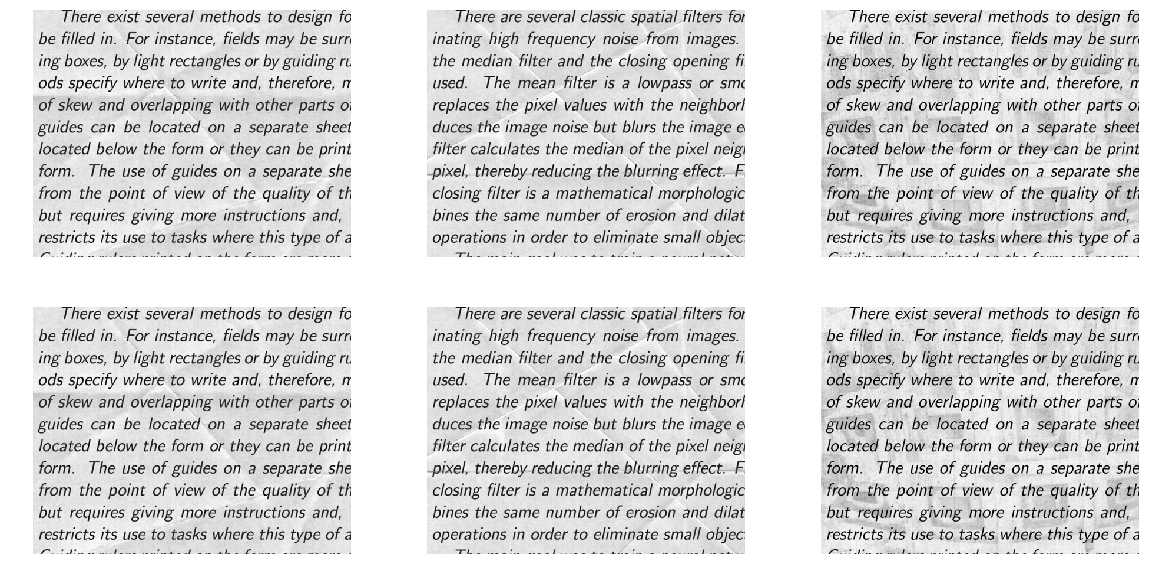

In [17]:
# The train directory comtaims png files. Let's get all the files and check a few samples
train_images = sorted(os.listdir(str(train)))
train_labels = sorted(os.listdir(str(train_cleaned)))
test_images = sorted(os.listdir(str(test)))
print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

# Lets' plot a few samples
# First row will be raw data, second row will be the corresponding cleaned images
samples = train_images[:3] + train_labels[:3]

f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    img = imread(str(train/img))
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show()  

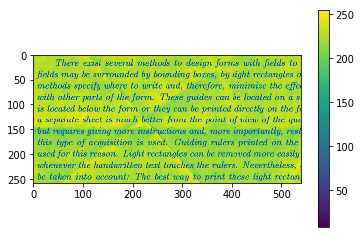

In [18]:
img = imread(str(train/'5.png'))
plt.imshow(img)
plt.colorbar()

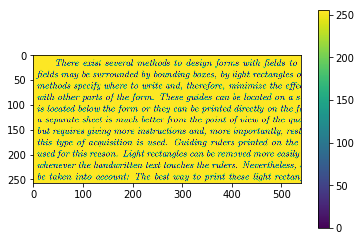

In [19]:
img_clean = imread(str(train_cleaned/'5.png'))
plt.imshow(img_clean)
plt.colorbar()

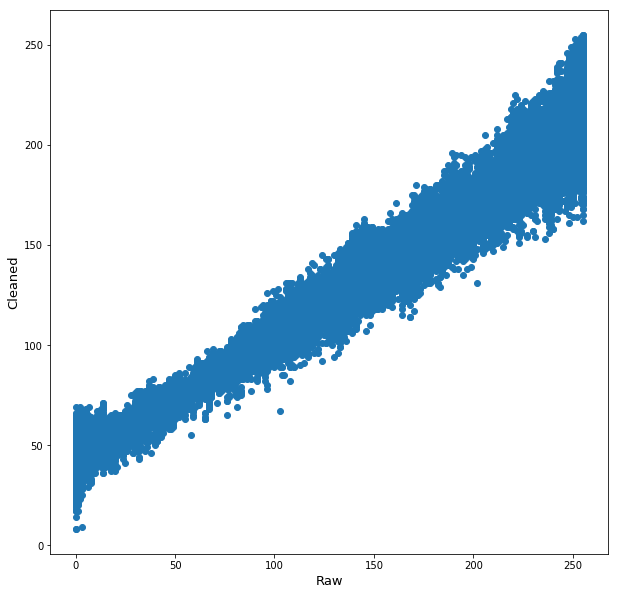

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(img_clean, img)
plt.ylabel('Cleaned', fontsize=13)
plt.xlabel('Raw', fontsize=13)
plt.show()

In [22]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(img, img_clean)
a = lin_reg.coef_[0]
b = lin_reg.intercept_

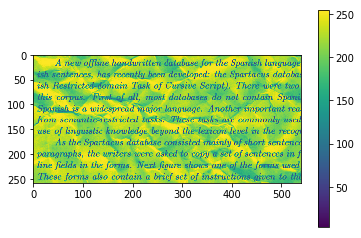

In [23]:
img_example = imread(str(test/'10.png'))
plt.imshow(img_example)
plt.colorbar()

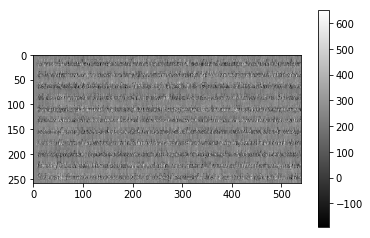

In [24]:
img_pred = lin_reg.predict(img_example)
plt.imshow(img_pred,cmap='gray')
plt.colorbar()

No esta mal para un modelo tan simple y con tan pocos datos. Pero como sabemos esto no es aplicable en nuestro problema (no tenemos datos de entrenamiento).

## 2.2 Thresholding

Exploramos otras tecnicas de procesamiento de imagenes. Primero el thresholding, que consiste en binarizar cada pixel de la imagen (asignar el color blanco o negro) en función de si la intensidad es mayo o menor a un umbral. También nos inspiramos de algunos ejemplos de la competencia de Kaggle para esto.

In [25]:
from PIL import Image

threshold=100

def discretize(a, threshold):
    return np.uint8((a > threshold)*255)

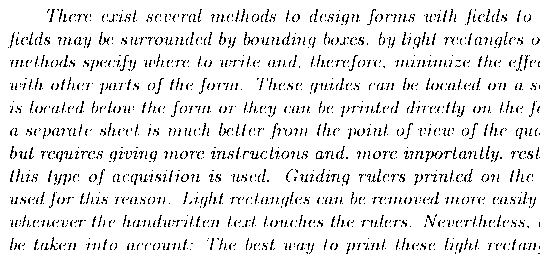

In [26]:
image_id = 10
dirty_image_path = str(train/'5.png')
clean_image_path = str(train_cleaned/'5.png')

dirty = Image.open(dirty_image_path)
clean = Image.open(clean_image_path)

clean_array = np.asarray(clean)
dirty_array = np.asarray(dirty)
    
threshold = 120
discretized_array = discretize(dirty_array, threshold)
Image.fromarray(discretized_array)

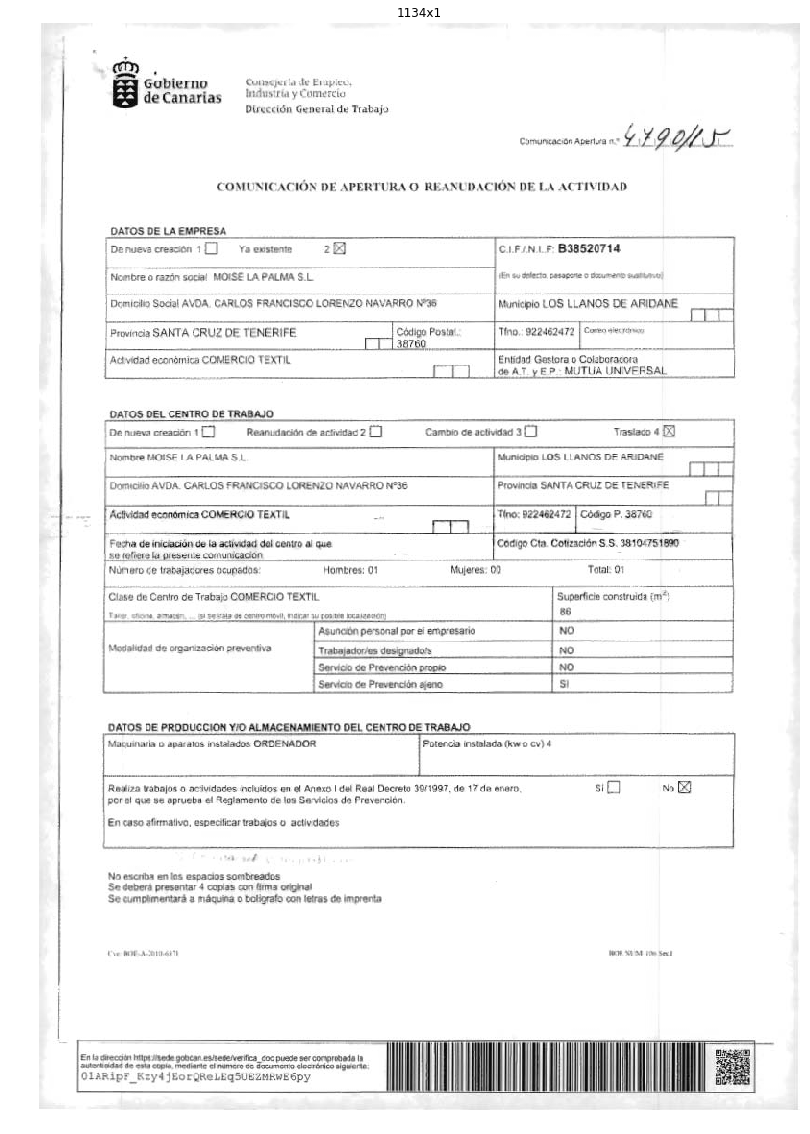

In [29]:
from keras.preprocessing.image import load_img, array_to_img, img_to_array

# Let's test our model on a sample test image
img_test = load_img("./data/Arte/test.png", grayscale=True)
img_test = img_to_array(img_test)
img_test_img = img_test.astype('float32')/255.
img_test_img = np.expand_dims(img_test, axis=0)

plt.figure(figsize=(20,20))
plt.title("{}x{}".format(img_test_img.shape[1], img_test_img.shape[0]))
plt.imshow(np.squeeze(img_test_img), cmap='gray')
plt.axis("off")
plt.show()

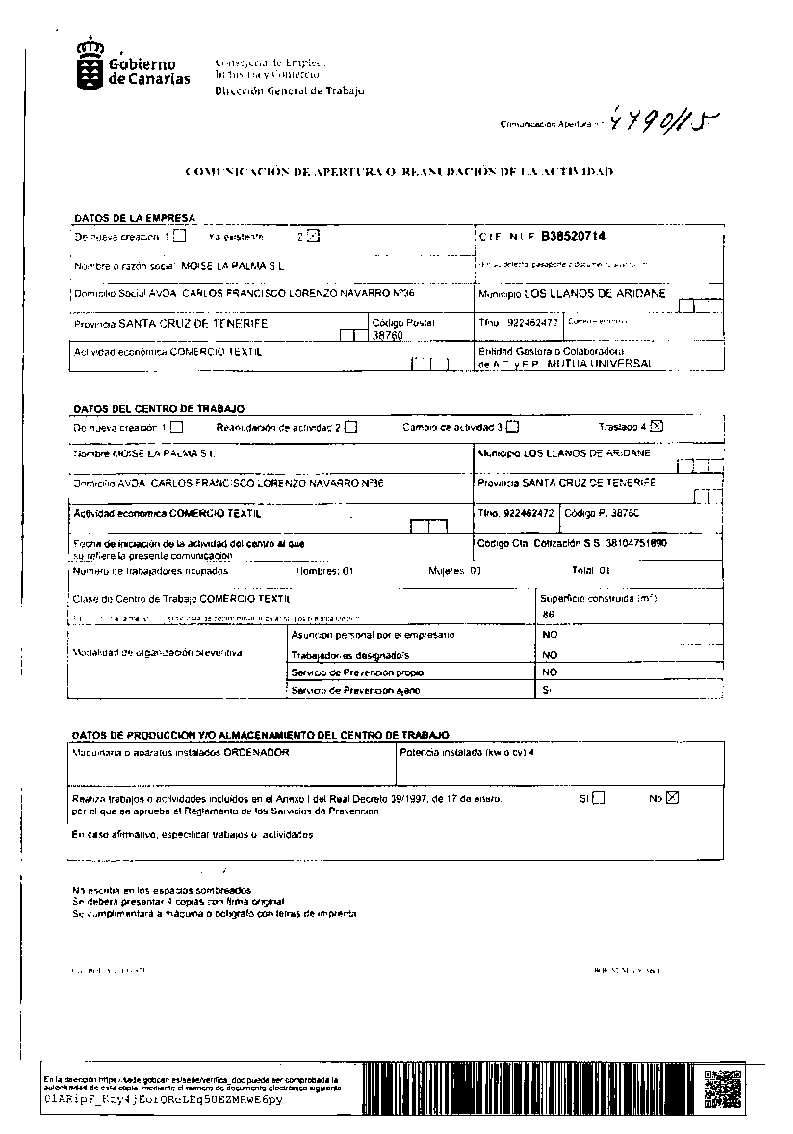

In [30]:
threshold = 170
discretized_array = discretize(np.squeeze(img_test_img), threshold)
Image.fromarray(discretized_array)

Observamos que efectivamente la tecnica limpia la imágen, pero también vemos que perdemos mucha información.

## 2.3 Eroding

Erosión, es simplemente erosionar cada elemento del texto borrando uno o varios pixeles esteriores. Utilizamos para esto la herramienta OpenCV:

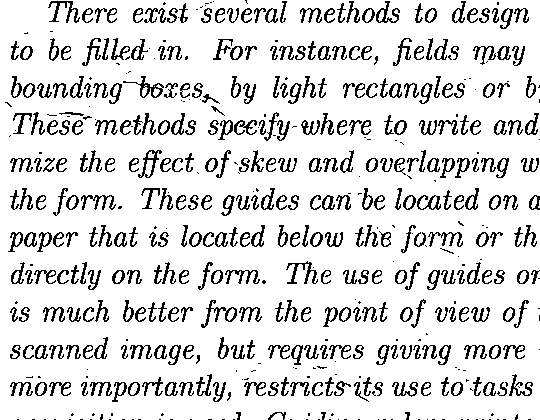

In [31]:
import os
import cv2
import numpy as np

img = cv2.imread("./data/KaggleDenoising/train/83.png", cv2.IMREAD_GRAYSCALE)

kernel = np.ones((4,4), np.uint8) 
#eroding image, remove text, leave background
img_erode  = 255 - cv2.erode(255 - img, kernel,iterations = 1)
#subtract background
img_sub = cv2.add(img, - img_erode)
_, img_thresh = cv2.threshold(img_sub, 200, 255, cv2.THRESH_BINARY)

Image.fromarray(img_thresh)

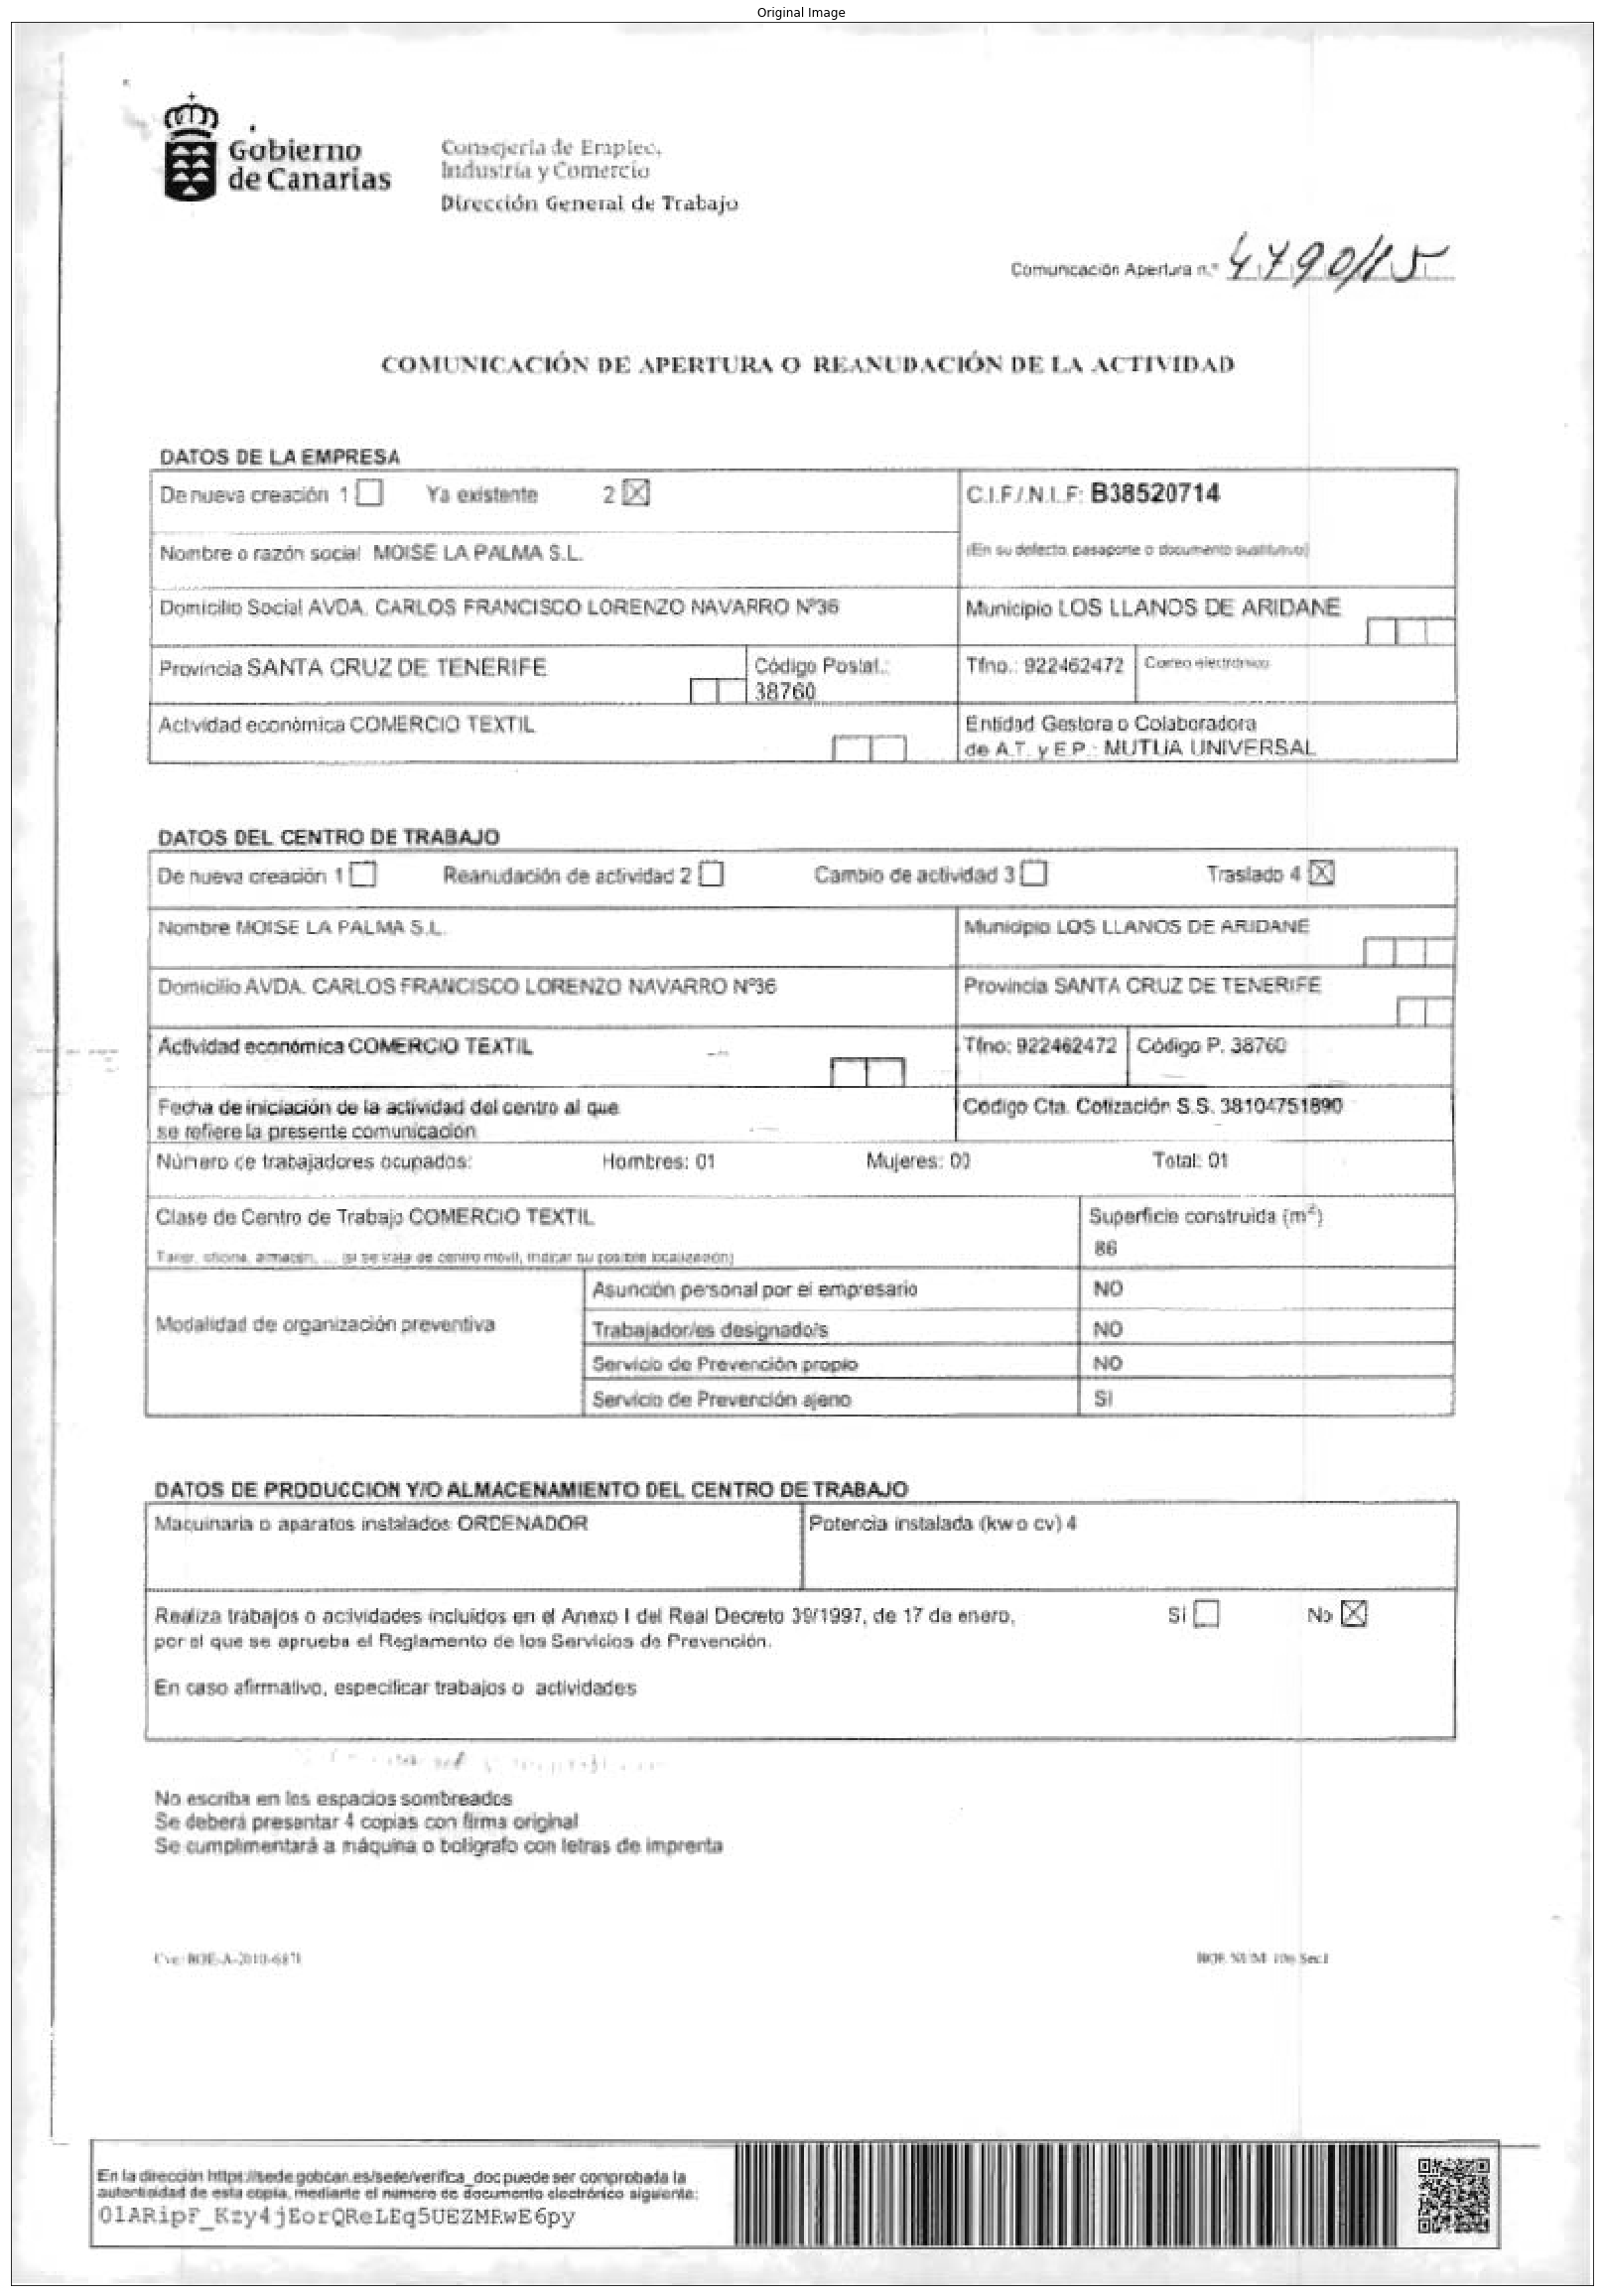

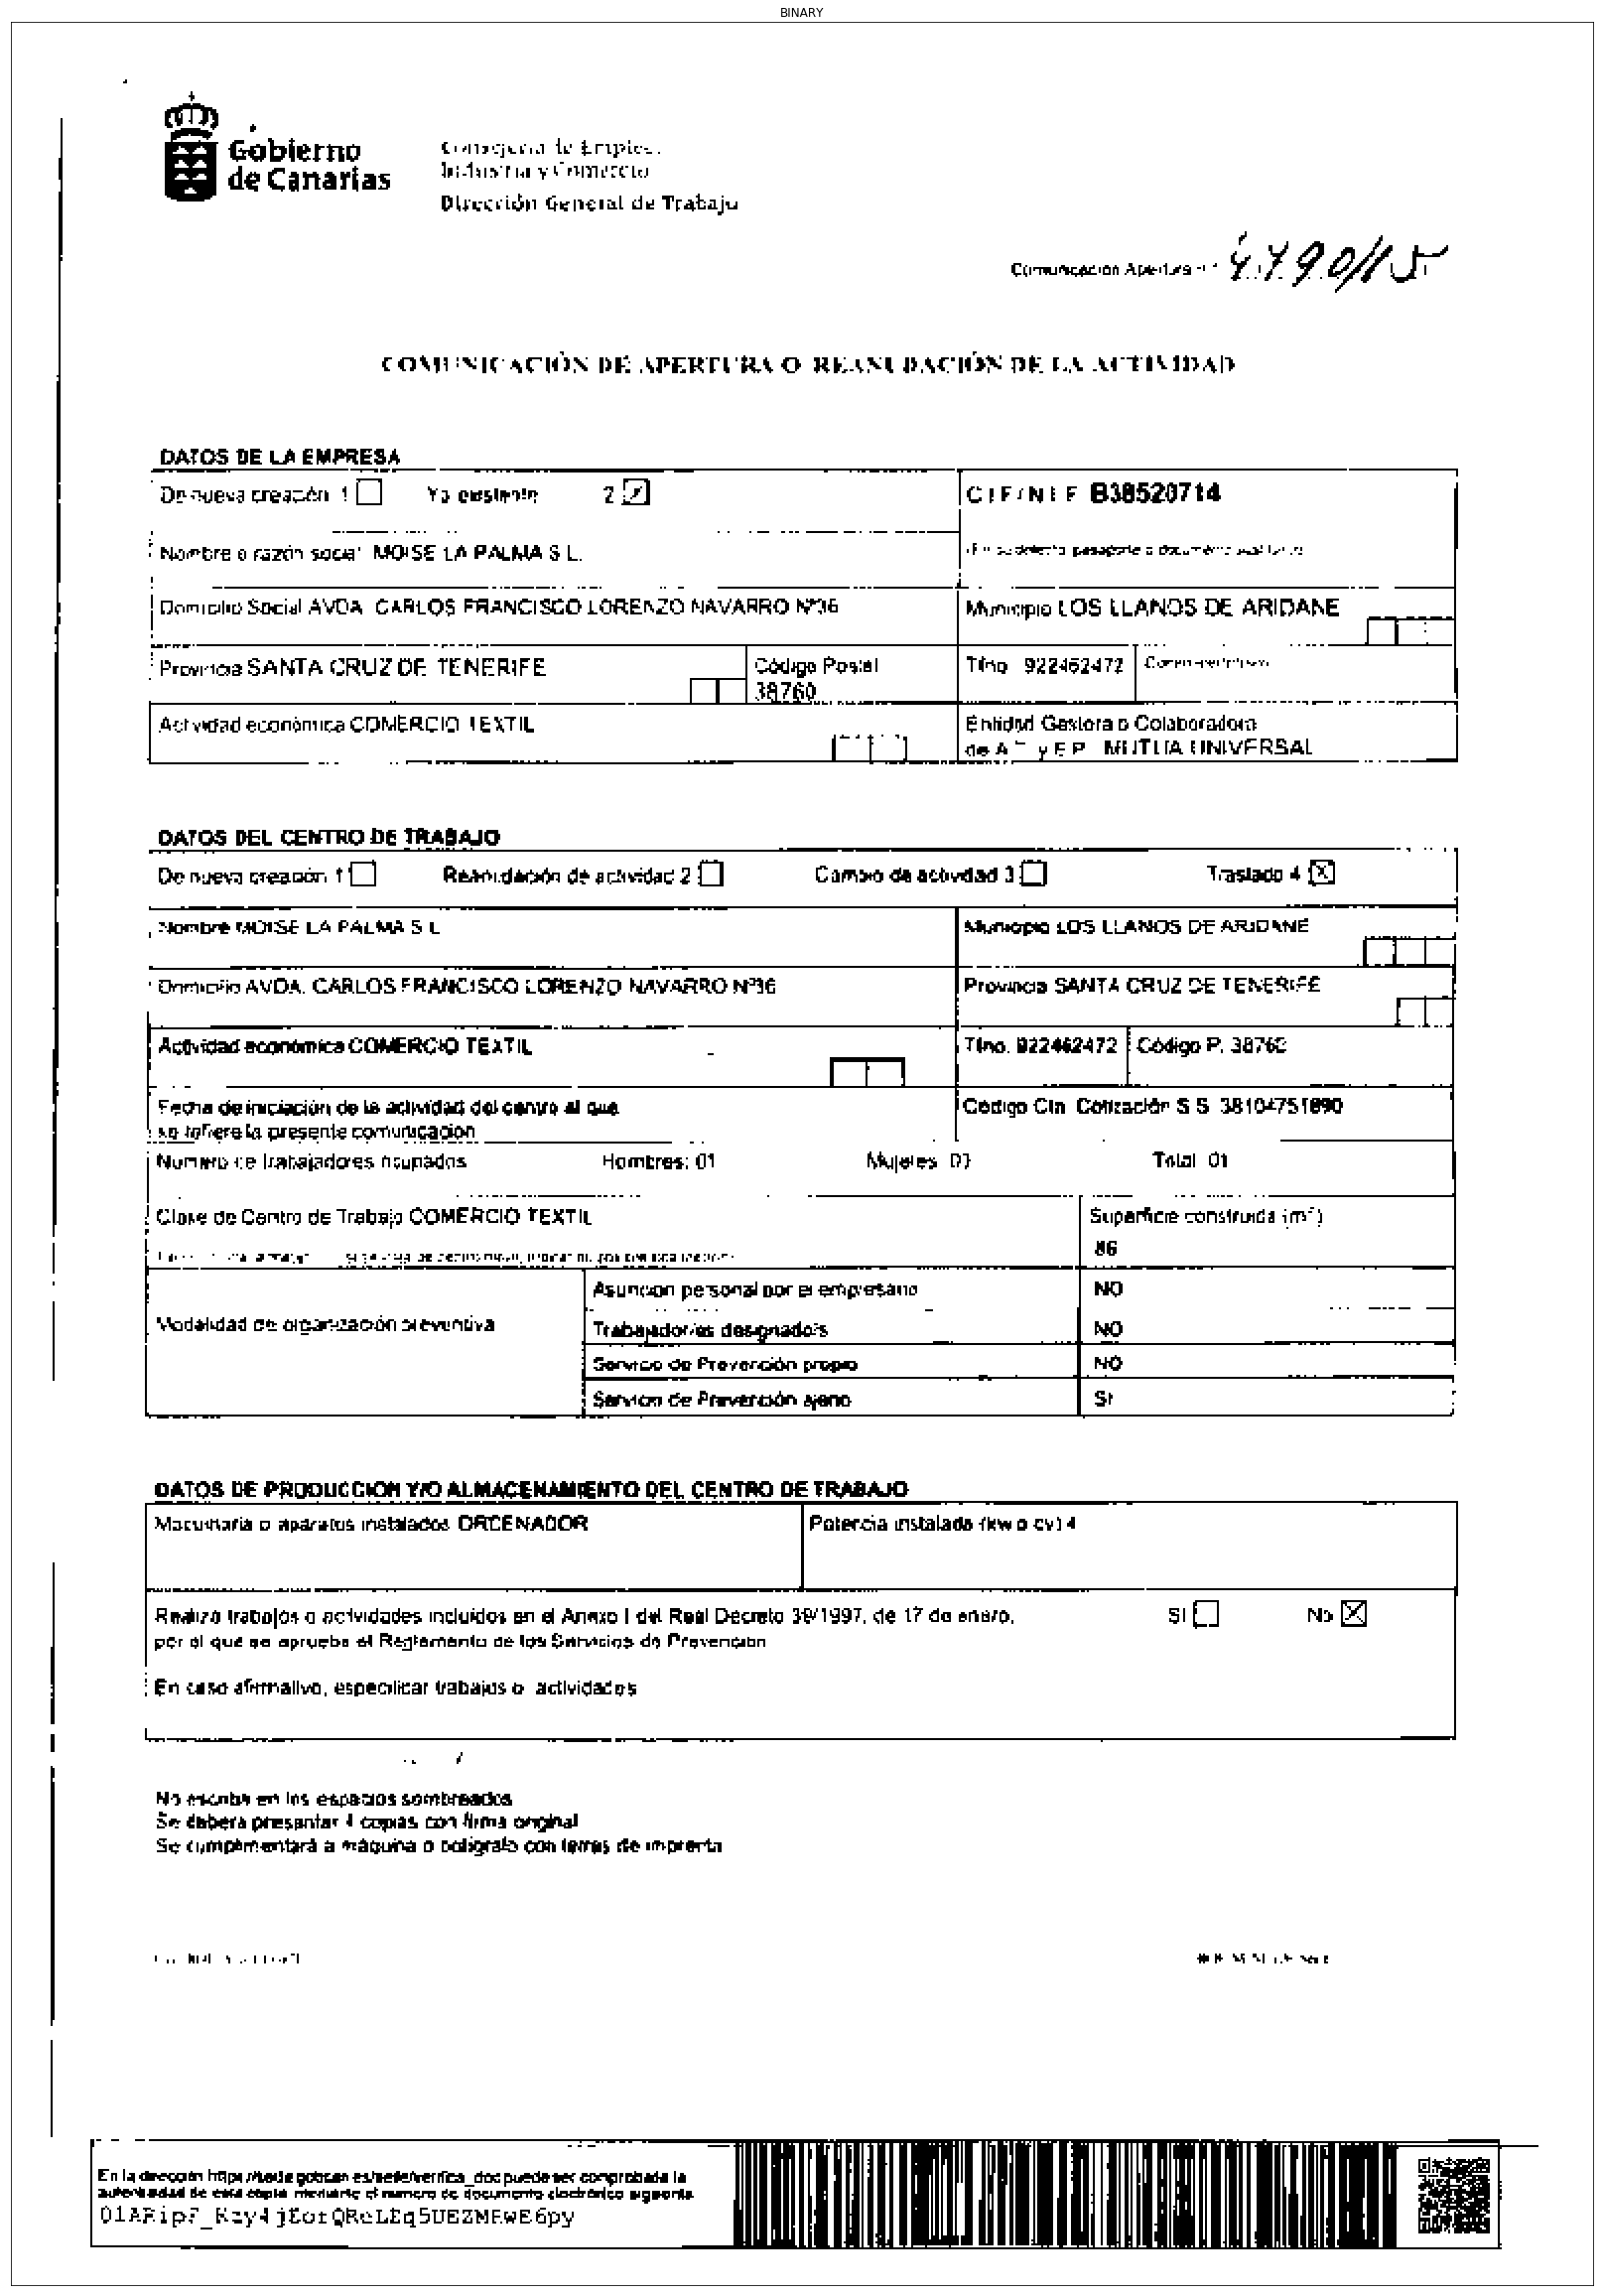

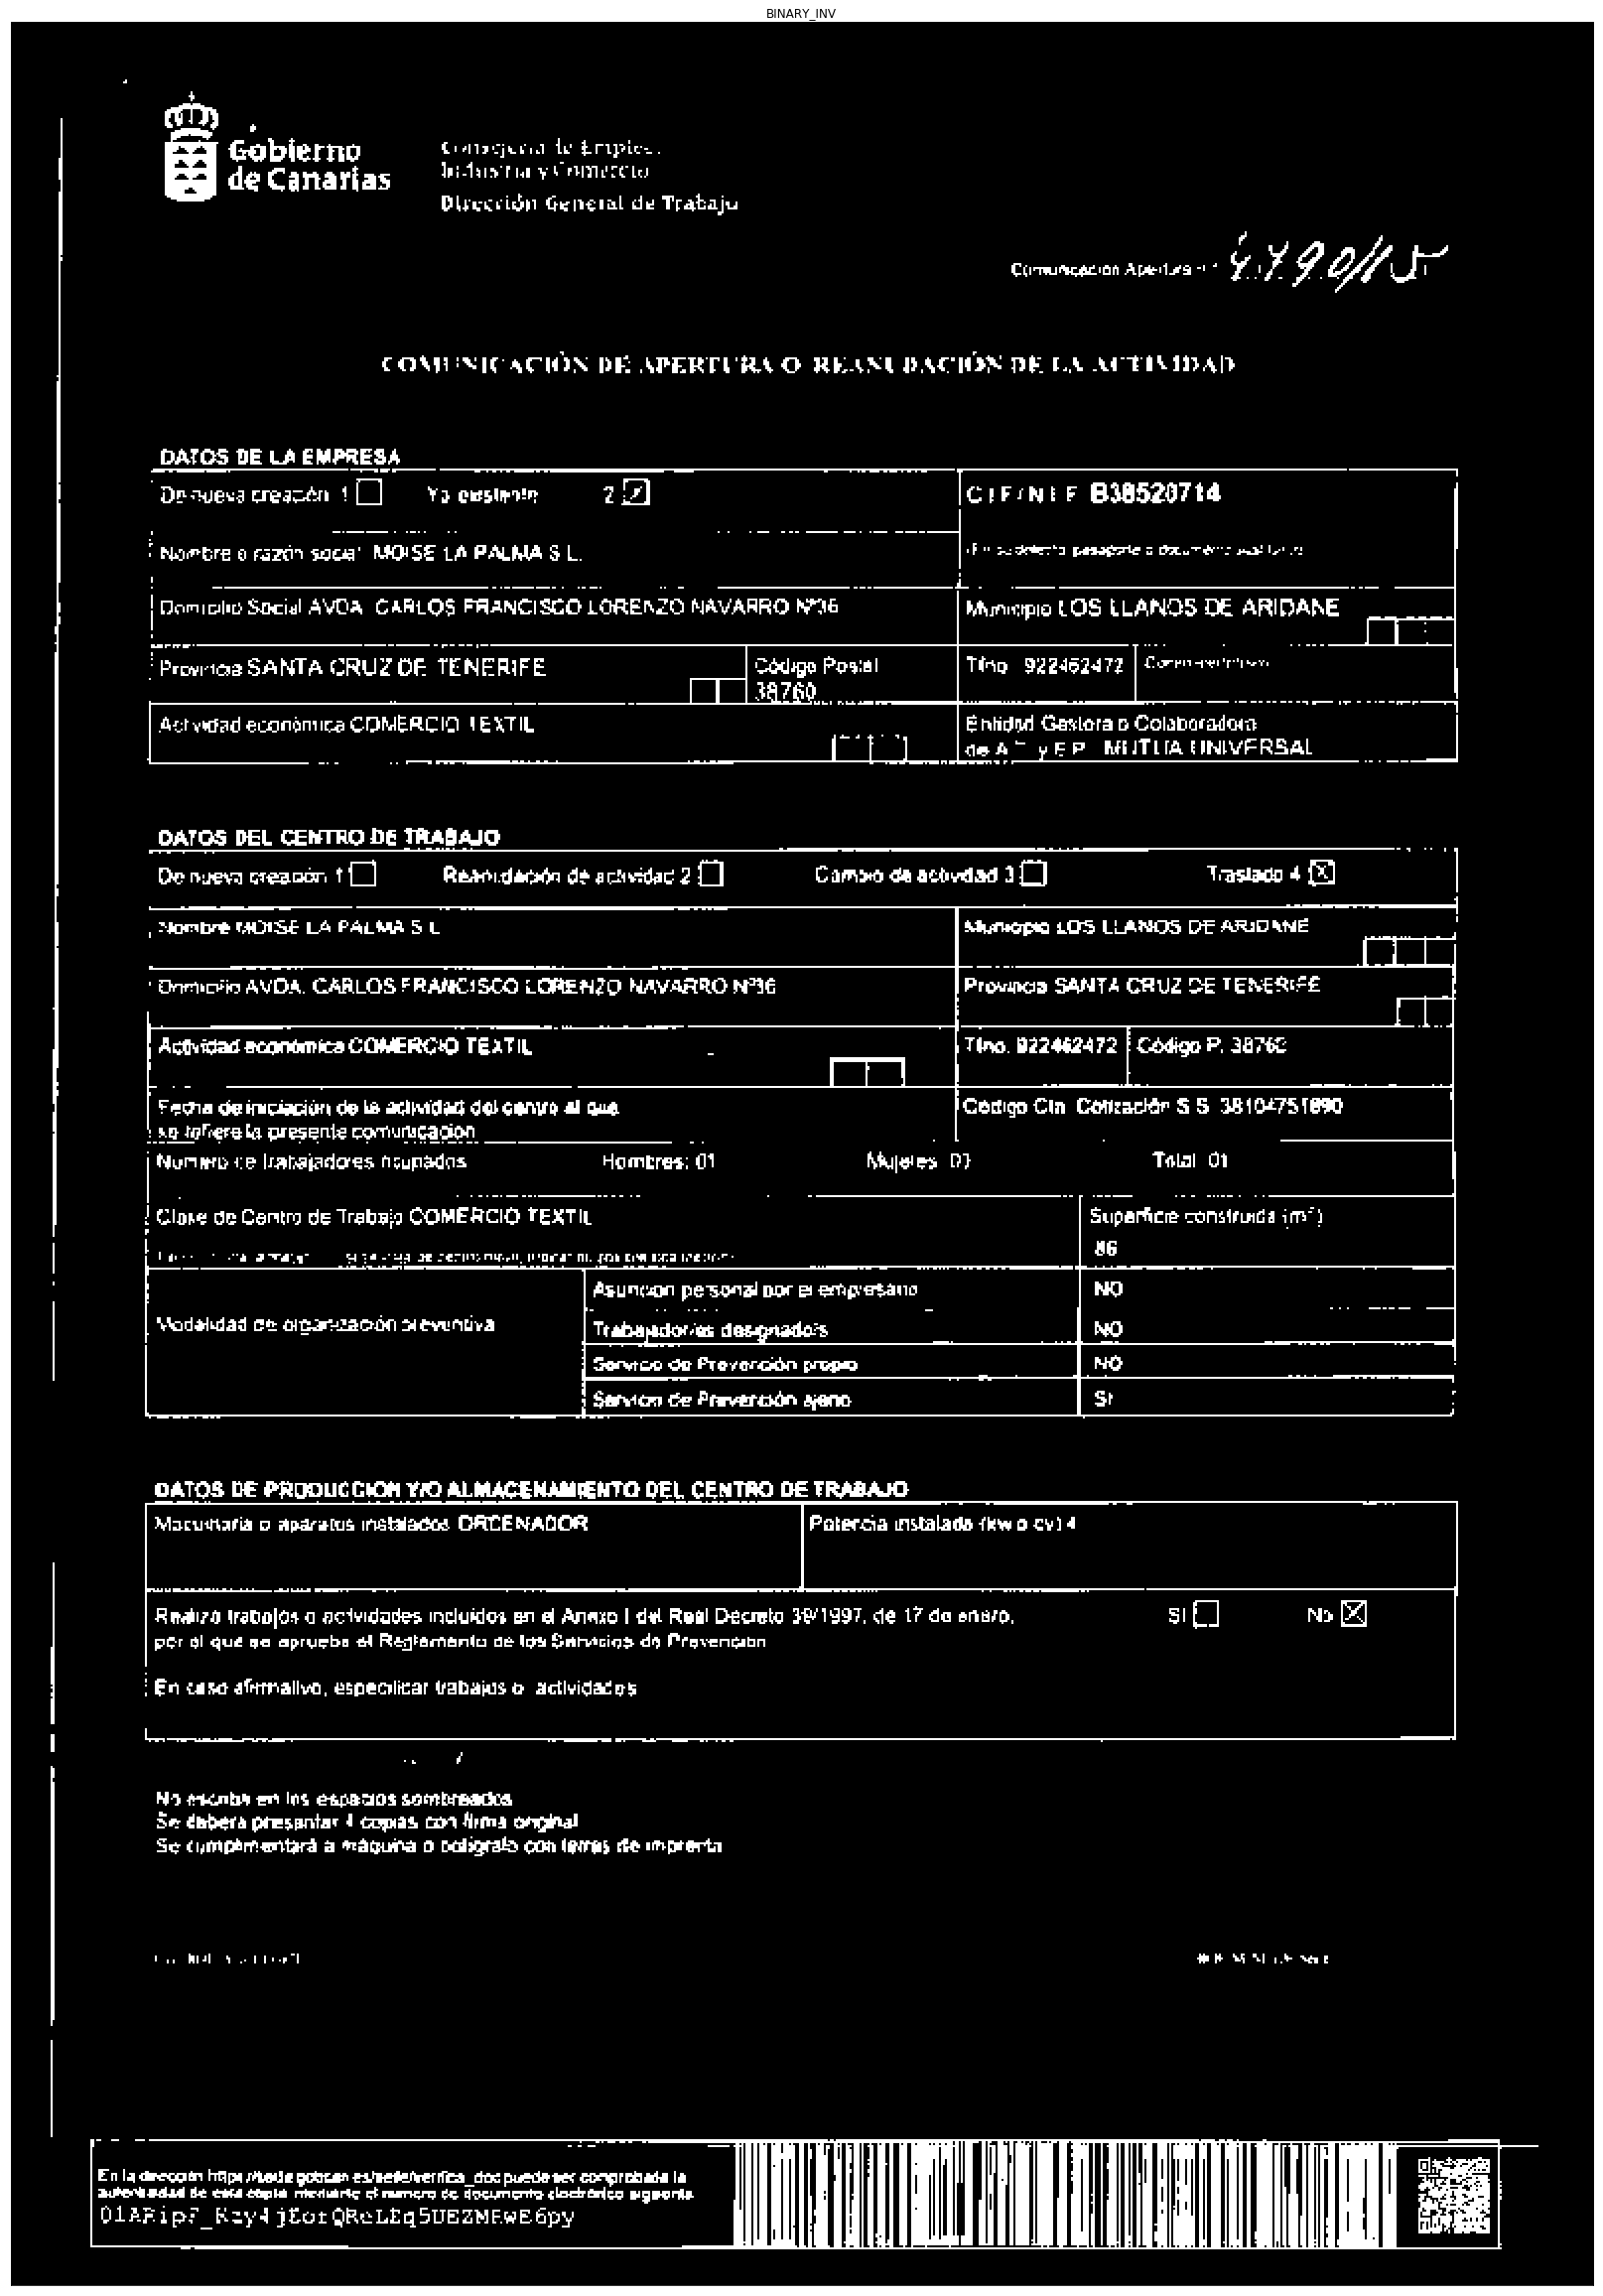

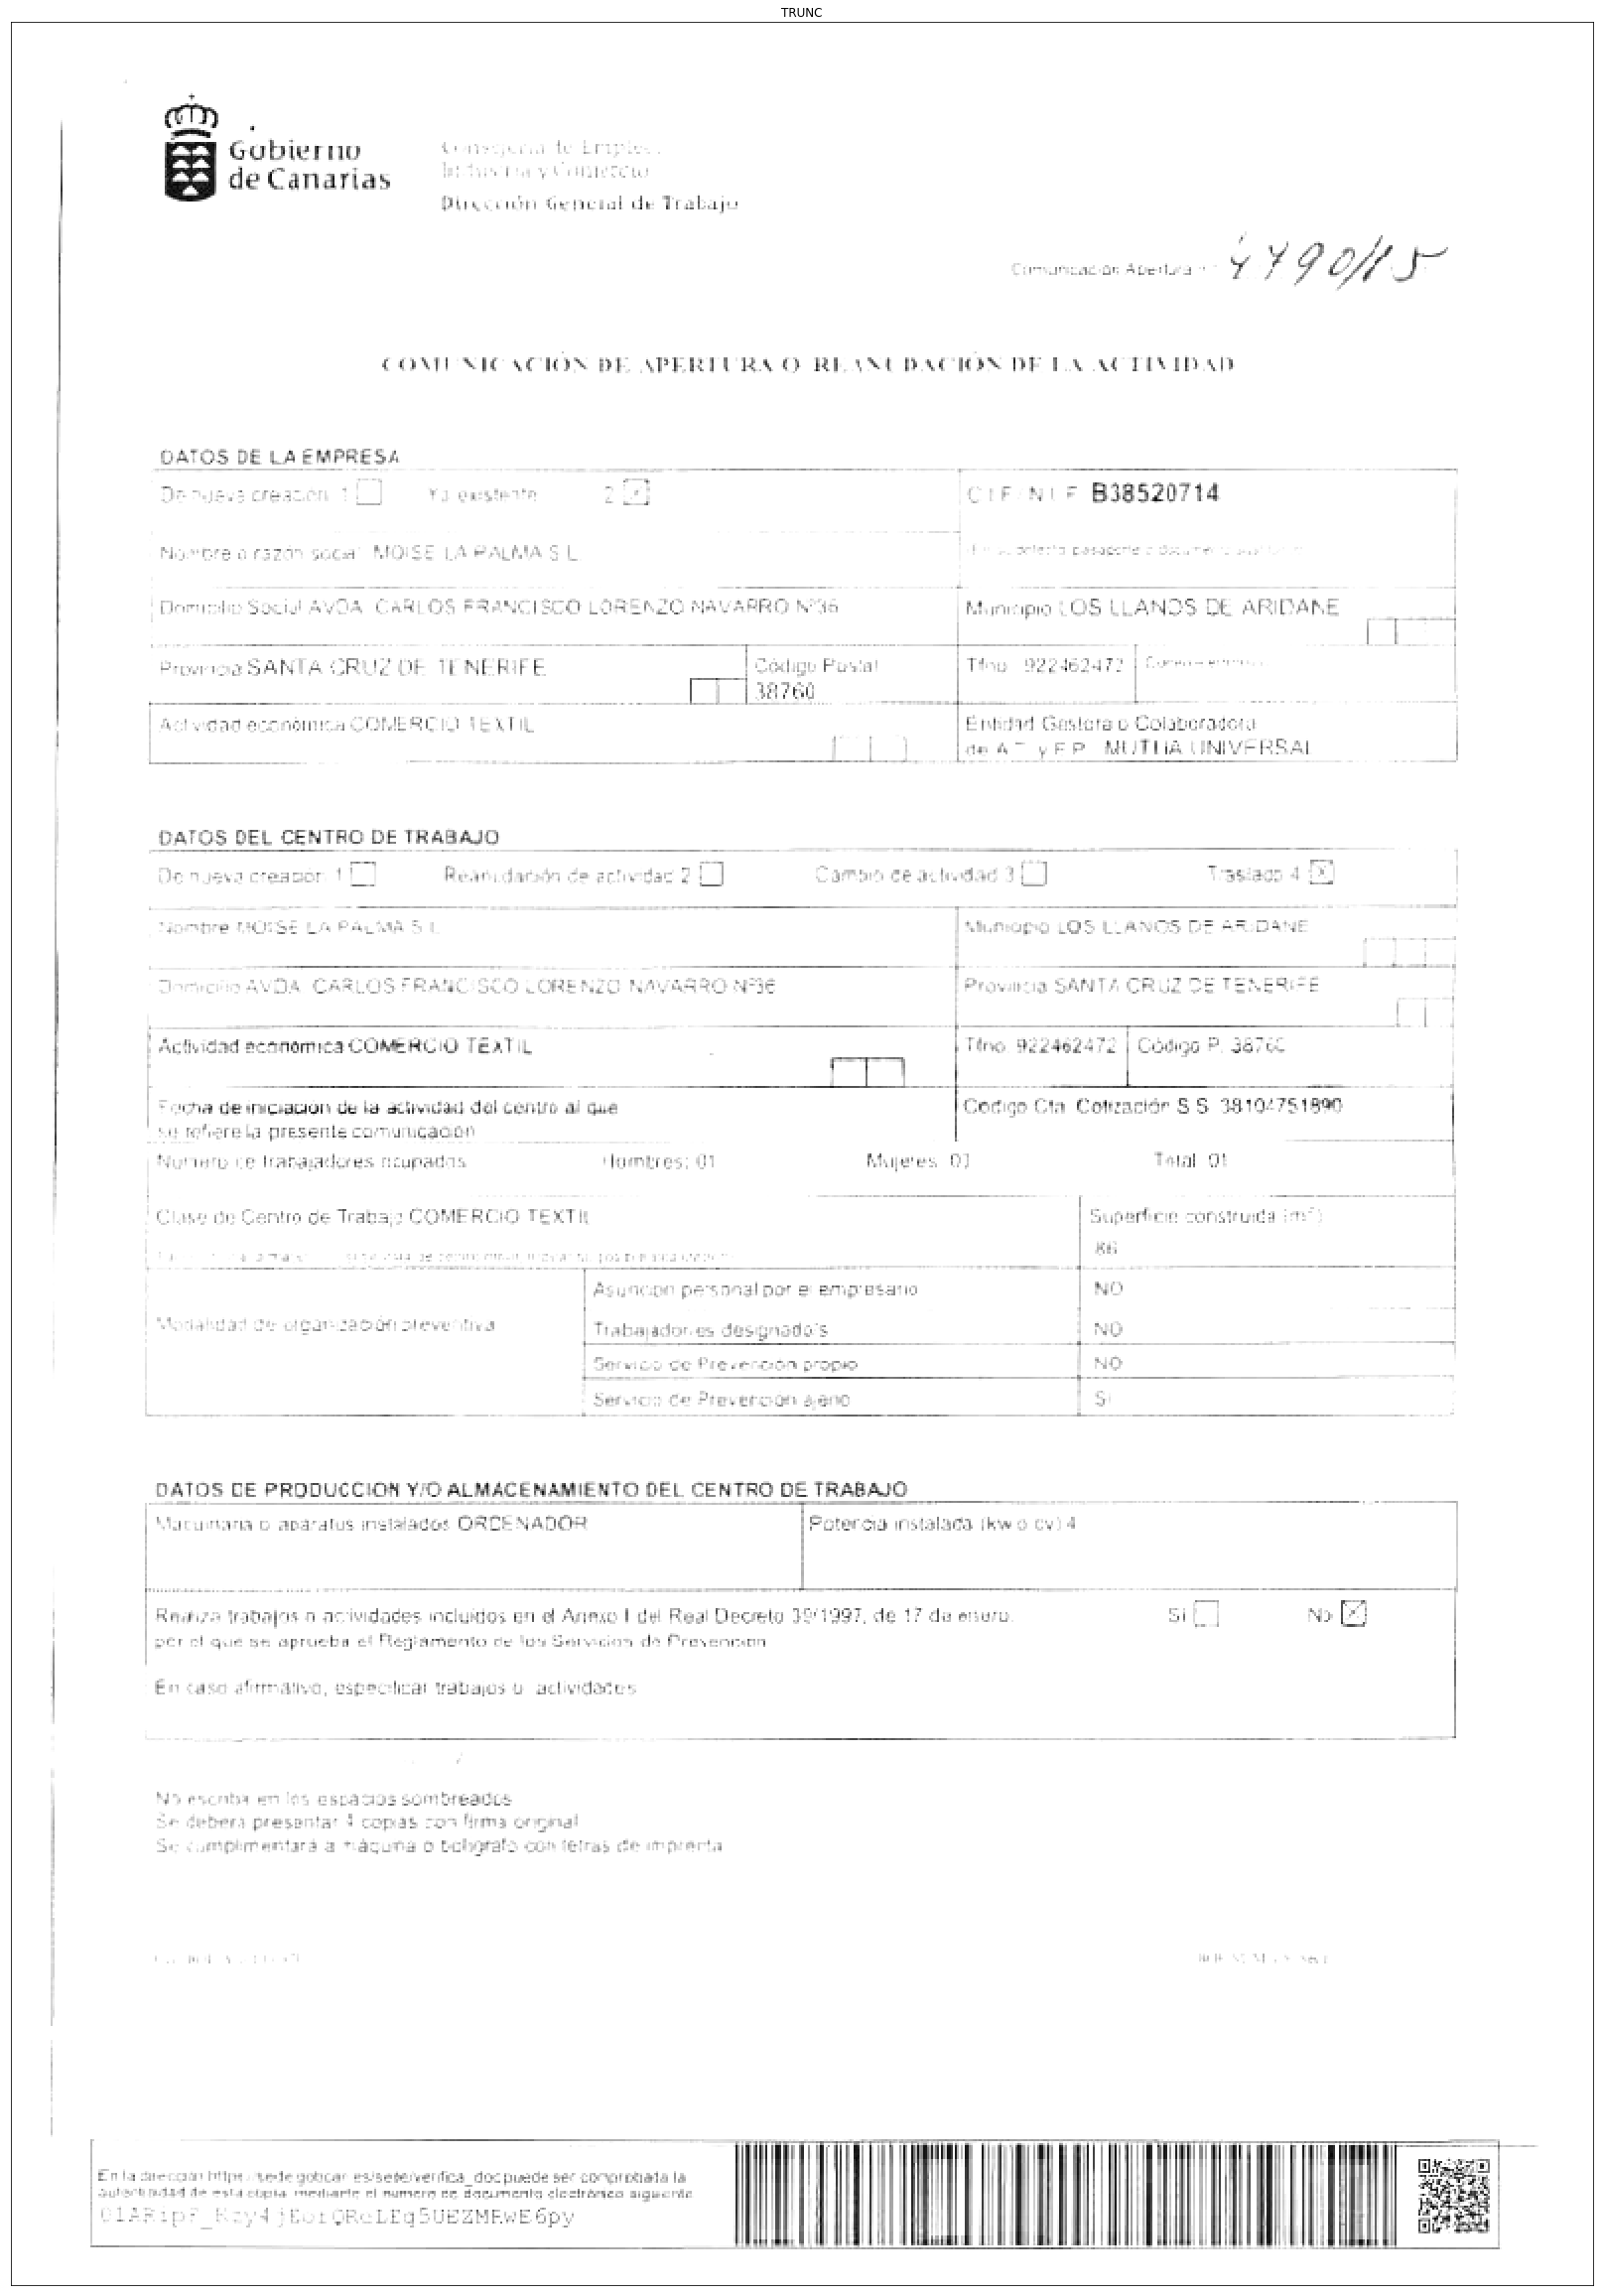

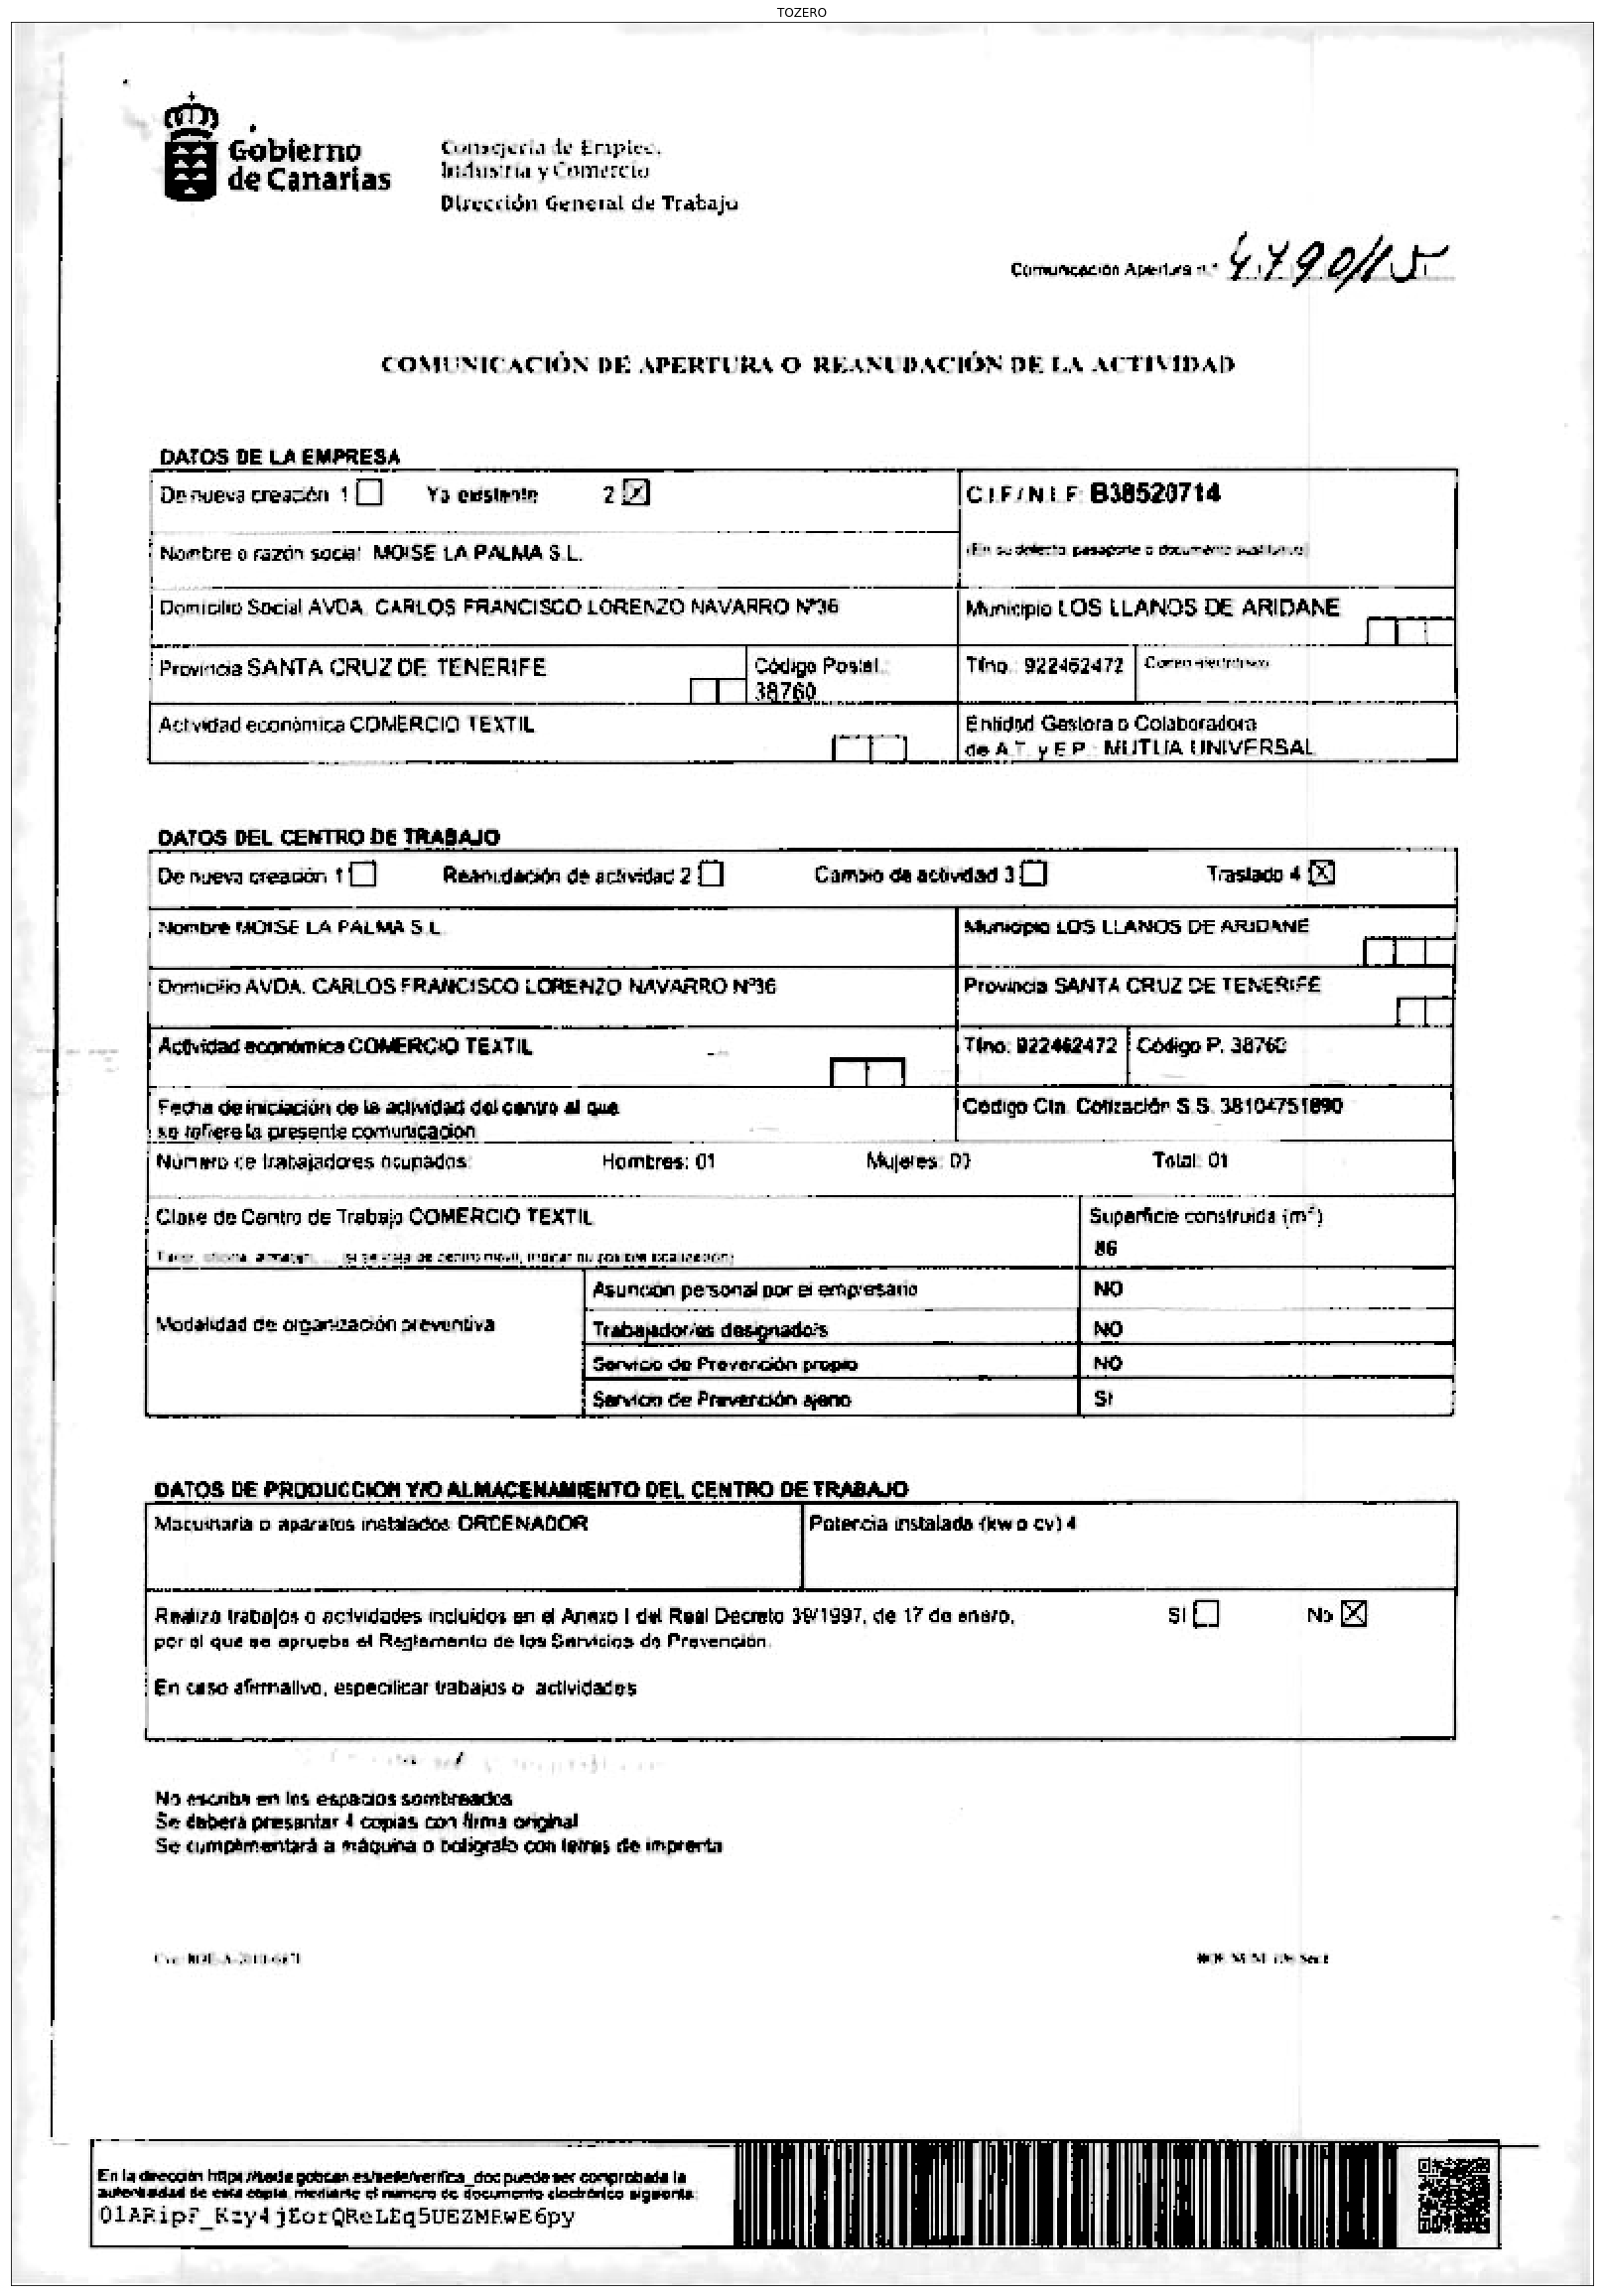

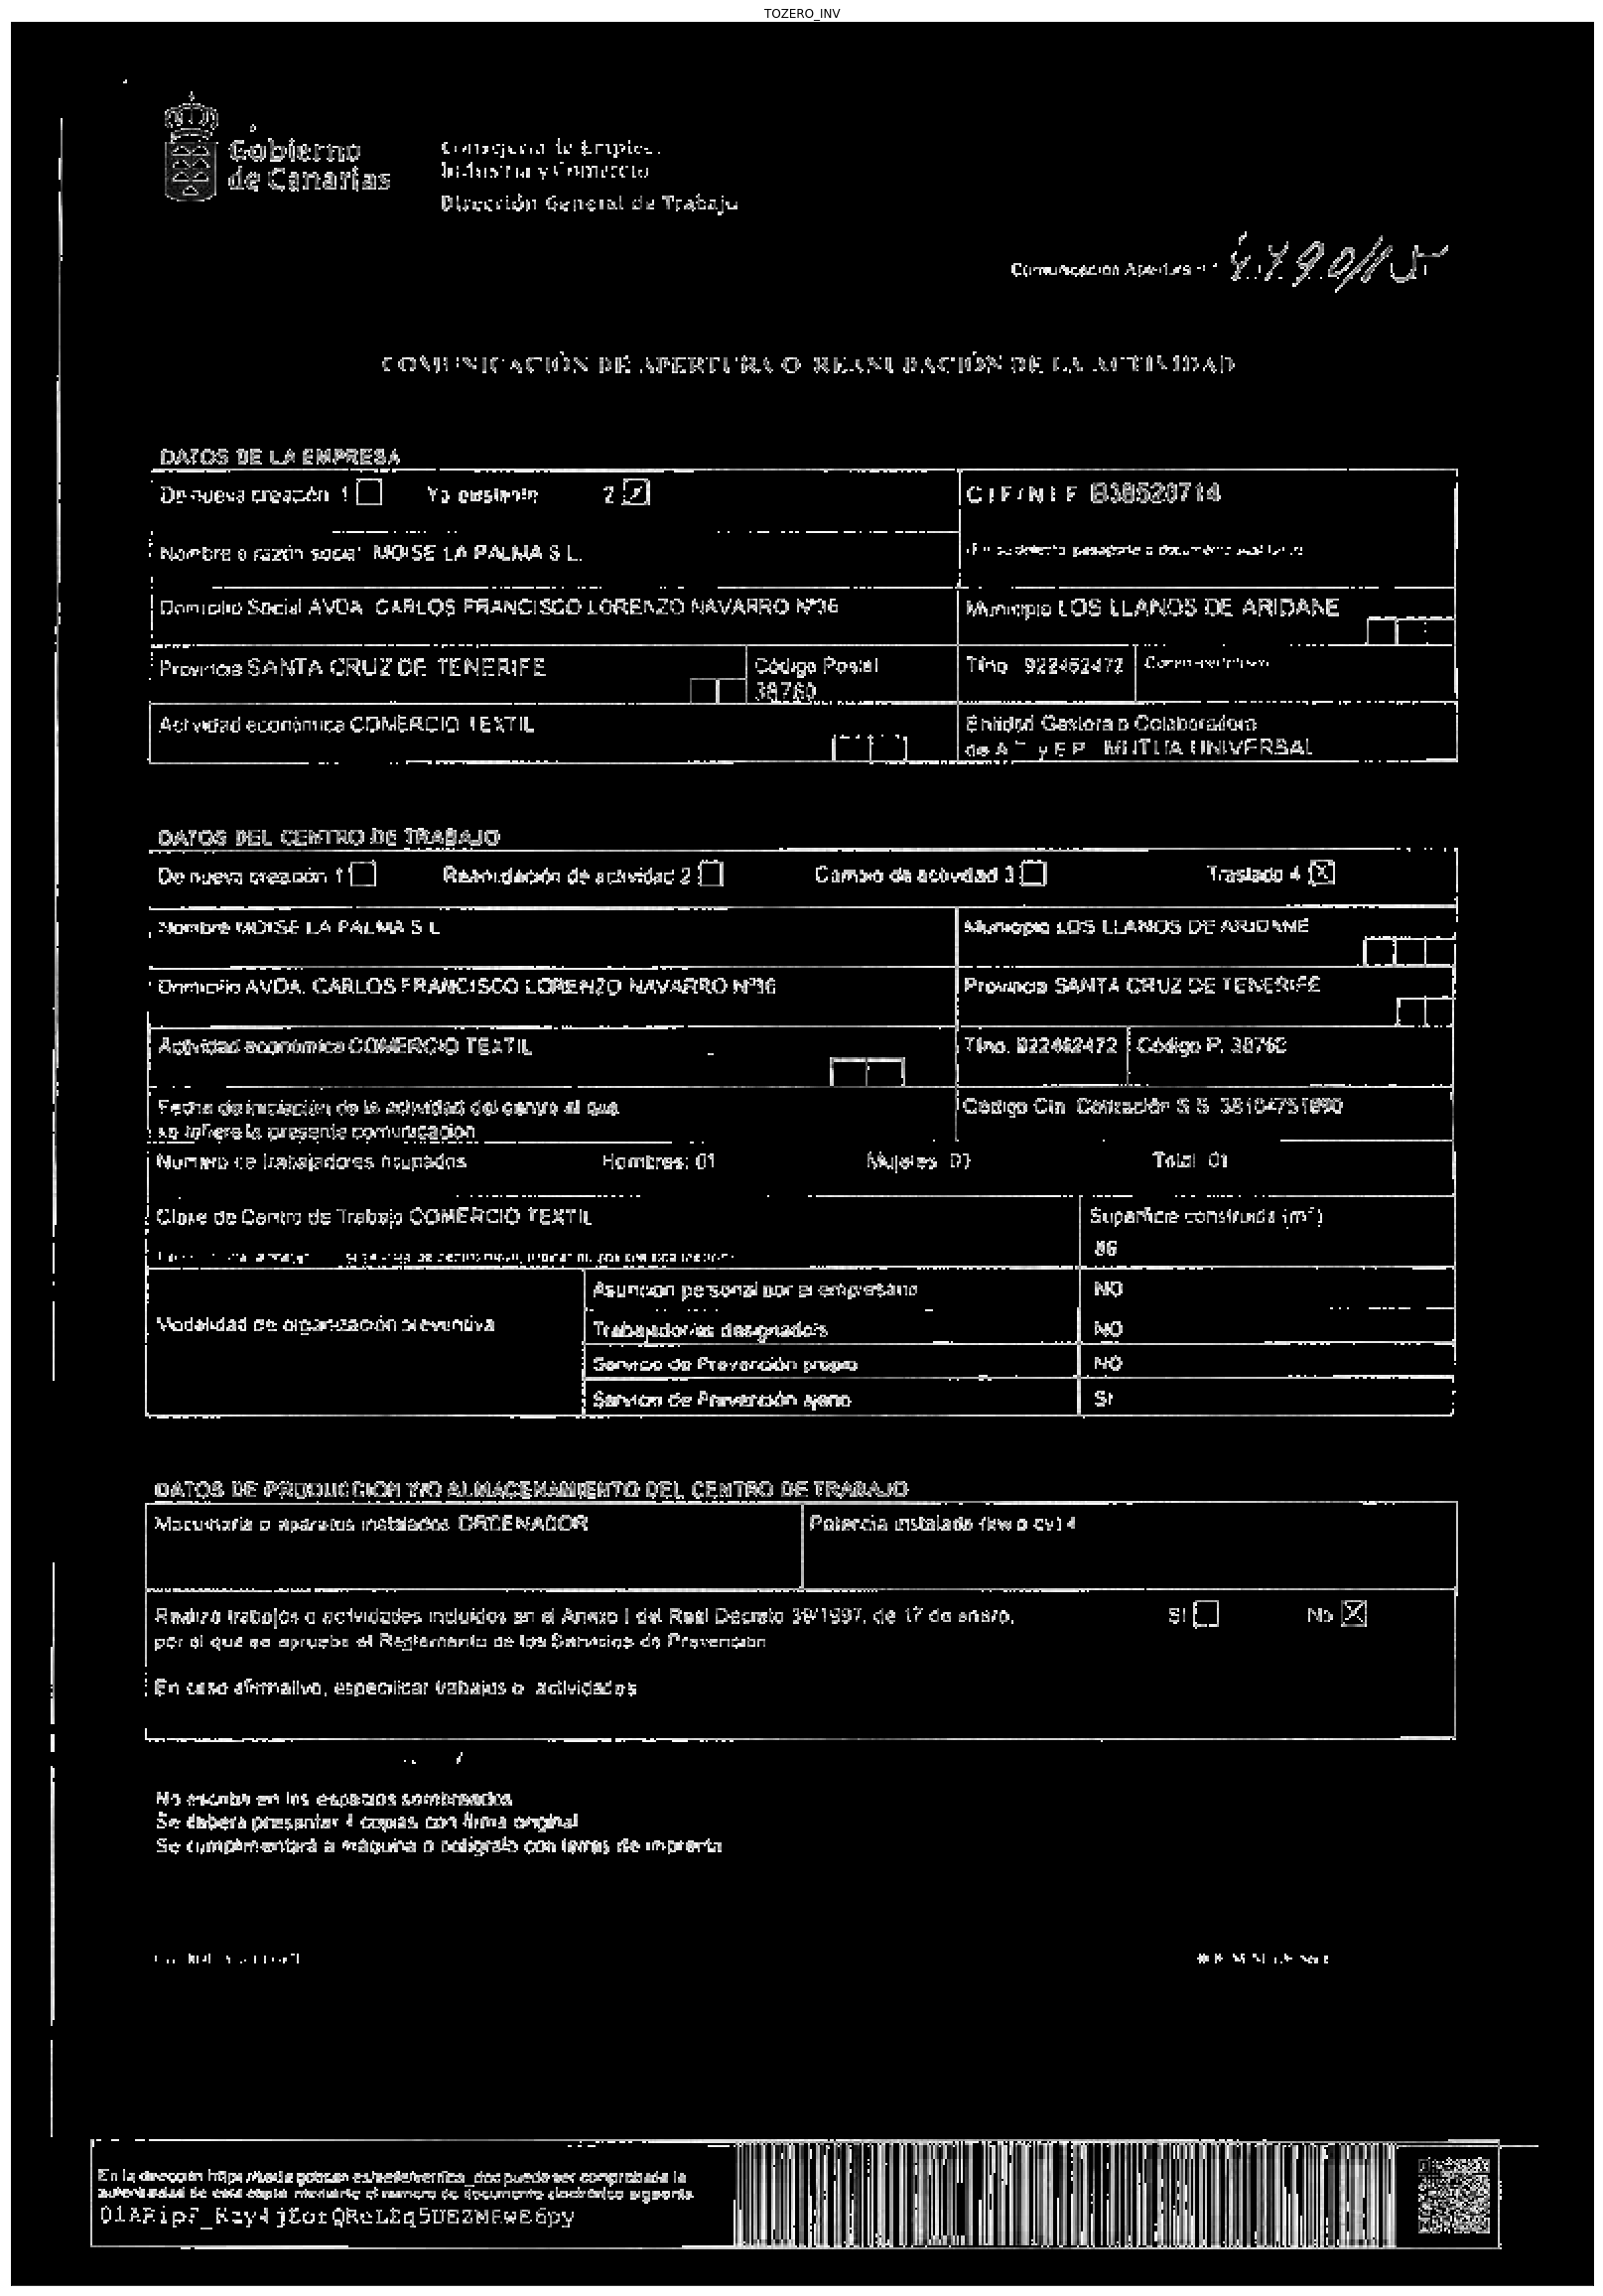

In [32]:
img = cv2.imread("./data/Arte/test.png", cv2.IMREAD_GRAYSCALE)

kernel = np.ones((4,4), np.uint8) 
#eroding image, remove text, leave background
img_erode  = 255 - cv2.erode(255 - img, kernel,iterations = 5)
#subtract background
img_sub = cv2.add(img, - img_erode)
_, img_thresh_binary = cv2.threshold(img_sub, 180, 255, cv2.THRESH_BINARY)
_, img_thresh_binaryinv = cv2.threshold(img_sub, 180, 255, cv2.THRESH_BINARY_INV)
_, img_thresh_trunc = cv2.threshold(img_sub, 180, 255, cv2.THRESH_TRUNC)
_, img_thresh_tozero = cv2.threshold(img_sub, 180, 255, cv2.THRESH_TOZERO)
_, img_thresh_tozeroinv = cv2.threshold(img_sub, 180, 255, cv2.THRESH_TOZERO_INV)

Image.fromarray(img_thresh)
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, img_thresh_binary,img_thresh_binaryinv, img_thresh_trunc, img_thresh_tozero, img_thresh_tozeroinv]

for i in xrange(6):
    plt.figure(figsize=(200,200))
    plt.subplot(2,6,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
    
#cv2.imwrite("0_original.png", img)
#cv2.imwrite("1_background.png", img_erode)
#cv2.imwrite("2_subtract_and_threshold.png", img_thresh)

Exploramos tambien otros metodos como el adaptive thresolding, además tenemos una herramienta sobre ImageMagik bastante fácil de utilizar para procesar imagenes:
    http://www.fmwconcepts.com/imagemagick/textcleaner/index.php

Aplicamos el umbral adaptable en función de la intensidad de los pixeles alrededor:

True

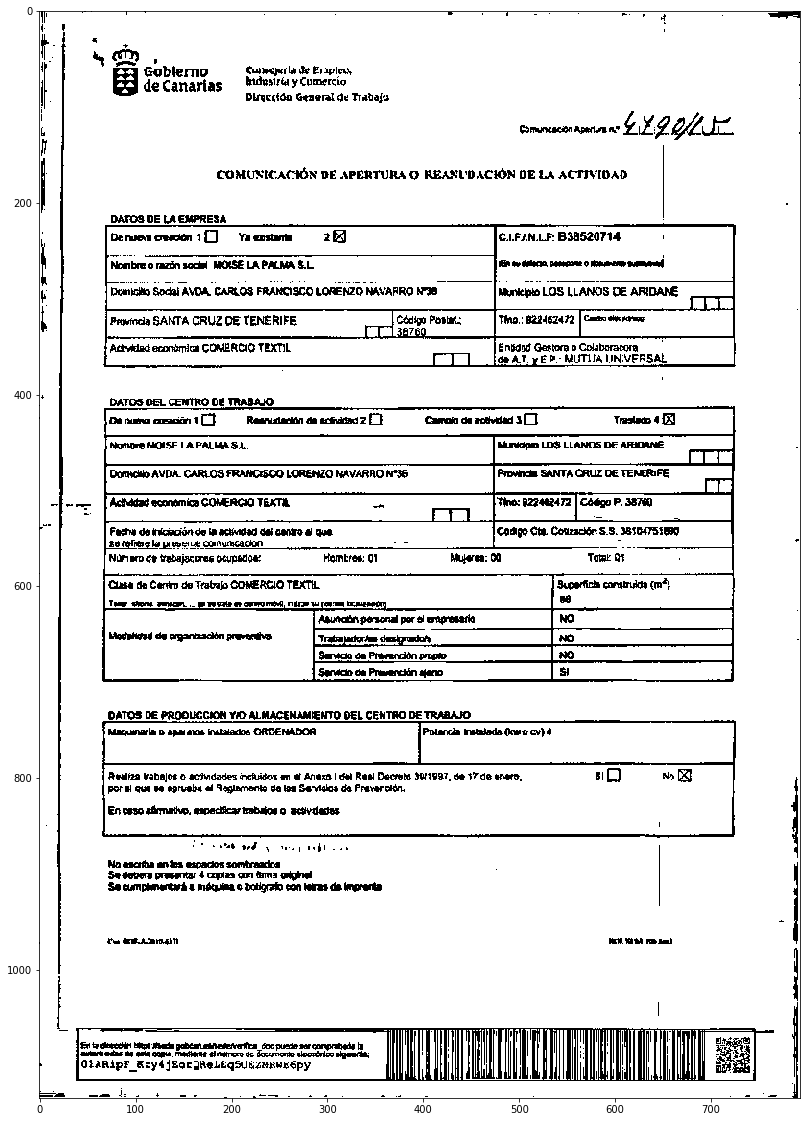

In [34]:
img = cv2.imread("./data/Arte/test.png", cv2.IMREAD_GRAYSCALE)
kernel = np.ones((6,6), np.uint8) 
#eroding image, remove text, leave background
img_erode  = 255 - cv2.erode(255 - img, kernel,iterations = 5)
img_sub = cv2.add(img, - img_erode)

img_thresh_adaptive = cv2.adaptiveThreshold(img_sub, 235, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,41,10)

plt.figure(figsize=(20,20))
plt.imshow(img_thresh_adaptive,'gray')

cv2.imwrite("./data/Arte/test_img_thresh_adaptive.png", img_thresh_adaptive)

Continuamos en el proximo notebook, en el cual exploramos la idea de Autoencoder para limpiar imágenes.

# 3. Evaluación del output de GoogleVision

In [4]:
import pandas as pd
#data_test = pd.read_json("./BMVC/in/gv_out_modeloA_blur3x3_1.json")
#data_test = pd.read_json("./BMVC/original/gv_out_modeloA_1.json")
#data_test = pd.read_json("./BMVC/out/gv_out_modeloA_blur3x3_1_out.json")
#data_test = pd.read_json("./BMVC/in/gv_out_test.json")
#data_test = pd.read_json("./BMVC/in/gv_out_test2.json")
#data_test = pd.read_json("./BMVC/out/gv_out_test_out.json")
data_test = pd.read_json("./BMVC/out/gv_out_test2_out.json")
print(data_test['responses'][0]['textAnnotations'][0]['description'])



Gobierno
de Canarias
Consejería de Empleo,
Industria y Comeicio
Dirección General de Trabajo
L
Comunicación Apertura n._ILU
Goco reservado para a adonatoon
Comunicación de apertura o reanudación de actividad (modelo A)
Datos de la empresa
De nueva creación C
Ya existente
X
Número documento NF I CF. Er su
defectc, pasaporta o documanto sustitutivo
Nombre
razón social IN
INVERSIONES TENESUR SL
B38973764
Municplo
Domlaitto CALLE MENCEY BENCOMO HERNANDEZ QUINTANA N° 48, C
LA OROTAVA
rrovincia
Col. postal Telefon
Correo electrónico
SANTA CRUZ DE TENERIFE
383001922.330.482 laversionestenosur@hotmail.com
Acimdac economica (CNAE 2009). Consulte ayuda se iNE http:/www inces EX INICOAV DACOO Enudad Eestora o colaboradora do A.T.E.P.
4121- CONSTRUCCION DE EDIFICIOS RESIDENCIALES
ASEPEYO
Datos del centro do trebalo
Do nuova creación
Reanudacion de actiudad
Caml de actividad
Traslado
Municipio
Norrbre INVERSIONES TENEBUR SL
LA OROTAVA
Provincia
Domicilio AVENIDA EMILIO LUQUE MORENO EDIFICIO 19 C 5.